# ML Group Case Study - Telecom Churn

From the dataset of Telecom customer, identify the high Profitable customers and predict the customers who are at high risk of churn.

Objective: 
1. Identify customers at high risk of churn
2. Identify the main indicators of churn

Prepaid customers churn identification is critical to business.
Define the term churn for prepaid customers
Data is also based on the Indian and South Asian Market where Prepaid users are more.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

 

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

 

In this project, you will use the usage-based definition to define churn.

 80% of revenue comes from the top 20% customers (called high-value customers). Predict churn only on High-value customers

# Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

# Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Import And Clean Data

Step by step Data Understanding, Cleaning, Missing Value Treatment and EDA was done and EDA results were interpreted.

After multiple iterations of going back and forth between Data Cleaning and Preprocessing and model building, arrived at a better design for Data Preprocessing steps, which is highly flexible for adding new steps and blocking existing steps in the pipeline, and thereby reduce time spent for preparing data before feeding to Models.

So organized the Data Preparing steps into Class and methods, such that the Calling step is able to chain the methods together, giving better readability to the code.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class DataCleaner():
    
    def __init__(self, df=None):
        self.df = df
    
    def import_and_describe_data(self):
        self.df=pd.read_csv('telecom_churn_data.csv')
        #print('------------------------------------DF Head-----------------------------------------')
        #print(self.df.head())
        #print('-------------------------------------Shape------------------------------------------')
        #print(self.df.shape)
        #print('--------------------------------------Info------------------------------------------')
        #print(self.df.info())
        return self

    def drop_single_value_columns(self):
        drop_cols = list(filter(lambda x : len(self.df[x].value_counts()) < 2, self.df.columns))
        #print('Columns to be dropped: {0}',drop_cols)
        self.df.drop(drop_cols,axis=1, inplace=True)   
        #print('---Columns remaining after cleanup----')
        #for x in self.df.columns:
        #    print(x)
        return self
    
    def tag_Churners(self):
        # Dataframe of only 9 month data for labelling
        churn_phase = self.df.loc[:,['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]

        # Check if missing values in Key columns involved in labelling Churned Customers
        #round((churn_phase.isnull().sum()/len(churn_phase.index))*100,2)

        churners = pd.DataFrame()
        churners =self.df.loc[(churn_phase.total_ic_mou_9 == 0.00) 
                            & (churn_phase.total_og_mou_9 == 0.00)
                            & (churn_phase.vol_2g_mb_9 == 0.00)
                            & (churn_phase.vol_3g_mb_9 == 0.00), ['mobile_number']
                           ]
        # Add new column for Churn
        churners['churn'] = 1

        #churners.head()

        # Merge 2 DF to all churn column
        self.df = pd.merge(self.df, churners, how='outer', on='mobile_number')
        self.df['churn'] = self.df['churn'].fillna(0)
        self.df['churn'] = self.df['churn'].astype(int)

        # Drop the 9th month columns (not needed for training model)
        mont_9_columns = list(map(lambda x : x.endswith('_9'),self.df.columns))

        self.df.drop(self.df.loc[:,mont_9_columns],axis = 1, inplace=True)
        #print('--Columns after ')
        #print(self.df.iloc[:,[0,1,-1]].head())
        
        return self
    
    def filter_High_Value_Customers(self):
        # Derive new column for Average Recharge Amount in 6 and 7 months
        self.df['d_av_rech_amt'] = round((self.df['total_rech_amt_6'] + self.df['total_rech_amt_7'])/2,2)
        self.df['d_av_rech_amt_data'] = round((self.df['av_rech_amt_data_6']+self.df['av_rech_amt_data_7'])/2,2)

        # Filter for High Value Customers
        self.df = self.df.loc[(self.df['d_av_rech_amt'] > self.df['d_av_rech_amt'].quantile(0.70)) |
                  (self.df['d_av_rech_amt_data'] > self.df['d_av_rech_amt_data'].quantile(0.70))]

        self.df.drop(['d_av_rech_amt','d_av_rech_amt_data'], axis=1, inplace=True)
        return self
    
    def remove_negative_arpu(self):
        # Remove all records with negative values in Revenue columns for Call usage.
        self.df = self.df.loc[(self.df.arpu_6 > 0) & (self.df.arpu_7 > 0) & (self.df.arpu_8 >0)]
        return self
    
    def drop_na(self):
        self.df.fillna(0,inplace=True)
        return self
    
    def drop_mobile_number_col(self):
        self.df.drop('mobile_number',axis=1,inplace=True)
        return self
    
    def fill_na(self):
        self.df.fillna(0,inplace=True)
        return self
    
    def impute_night_pack_user(self):
        self.df['night_pck_user_6'] =self.df.loc[:,'night_pck_user_6'].fillna(-1).astype(int)
        self.df['night_pck_user_7'] =self.df.loc[:,'night_pck_user_7'].fillna(-1).astype(int)
        self.df['night_pck_user_8'] =self.df.loc[:,'night_pck_user_8'].fillna(-1).astype(int)
        return self
    
    def impute_fb_user(self):
        self.df['fb_user_6'] =self.df.loc[:,'fb_user_6'].fillna(-1).astype(int)
        self.df['fb_user_7'] =self.df.loc[:,'fb_user_7'].fillna(-1).astype(int)
        self.df['fb_user_8'] =self.df.loc[:,'fb_user_8'].fillna(-1).astype(int)
        return self
    
    def fix_column_names(self):
        self.df.rename(columns={'jun_vbc_3g': 'vbc_3g_6',
                                'jul_vbc_3g': 'vbc_3g_7',
                                'aug_vbc_3g': 'vbc_3g_8',
                                'sep_vbc_3g': 'vbc_3g_9'
                               }, inplace=True)
        return self

In [3]:
cleaned_df = ( DataCleaner()
    .import_and_describe_data()
    .drop_single_value_columns()
    .fix_column_names()
    .tag_Churners()
    .filter_High_Value_Customers()
    .remove_negative_arpu() # Remove EDA identified negative values in ARPU
   #.drop_na()
    .impute_night_pack_user()       
    .impute_fb_user()  
    .fill_na()
    #.drop_mobile_number_col()
).df

In [4]:
cleaned_df.shape

(30343, 159)

# EDA

### Check if all the rows are unique. Mobile number is the Unique key, and no duplicate rows were found

In [5]:
# Get unique value count, sort in descending order and get top 10 items
cleaned_df.mobile_number.value_counts().sort_values(ascending = False)[0:10]

7000883200    1
7000934425    1
7000346682    1
7002376249    1
7001344001    1
7000891396    1
7001292808    1
7001557001    1
7000971275    1
7001366540    1
Name: mobile_number, dtype: int64

Understand the datatype of all the columns as first step of EDA. This is done in batch of 40 items, to look at the Columns one by one.

In [6]:
cleaned_df.iloc[:,0:40].info()
cleaned_df.iloc[:,40:80].info()
cleaned_df.iloc[:,80:130].info()
cleaned_df.iloc[:,130:160].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30343 entries, 0 to 99997
Data columns (total 40 columns):
mobile_number       30343 non-null int64
arpu_6              30343 non-null float64
arpu_7              30343 non-null float64
arpu_8              30343 non-null float64
onnet_mou_6         30343 non-null float64
onnet_mou_7         30343 non-null float64
onnet_mou_8         30343 non-null float64
offnet_mou_6        30343 non-null float64
offnet_mou_7        30343 non-null float64
offnet_mou_8        30343 non-null float64
roam_ic_mou_6       30343 non-null float64
roam_ic_mou_7       30343 non-null float64
roam_ic_mou_8       30343 non-null float64
roam_og_mou_6       30343 non-null float64
roam_og_mou_7       30343 non-null float64
roam_og_mou_8       30343 non-null float64
loc_og_t2t_mou_6    30343 non-null float64
loc_og_t2t_mou_7    30343 non-null float64
loc_og_t2t_mou_8    30343 non-null float64
loc_og_t2m_mou_6    30343 non-null float64
loc_og_t2m_mou_7    30343 non-nul

## Understanding Data : Univariate Analysis on Numeric Variables

Summary metrics are looked in batch of 20 columns, and Observations are summarized in EDA Summary Section below.

In [7]:
print('Summary metrics - Numeric Variables')

numeric_df = (cleaned_df.iloc[:,0:20])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (cleaned_df.iloc[:,20:40])._get_numeric_data()
print(numeric_df.describe())
  
numeric_df = (cleaned_df.iloc[:,40:60])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (cleaned_df.iloc[:,60:80])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (cleaned_df.iloc[:,80:100])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (cleaned_df.iloc[:,100:120])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (cleaned_df.iloc[:,120:140])._get_numeric_data()
print(numeric_df.describe())

numeric_df = (cleaned_df.iloc[:,140:160])._get_numeric_data()
print(numeric_df.describe())

Summary metrics - Numeric Variables
       mobile_number        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count   3.034300e+04  30343.000000  30343.000000  30343.000000  30343.000000   
mean    7.001224e+09    567.181066    578.277537    534.774667    280.637214   
std     6.832551e+05    427.968625    457.995911    482.392632    449.174770   
min     7.000000e+09      0.040000      0.020000      0.010000      0.000000   
25%     7.000645e+09    348.105000    354.232500    288.595500     34.610000   
50%     7.001236e+09    477.291000    482.293000    447.185000    115.610000   
75%     7.001813e+09    680.429500    688.561500    664.236000    330.785000   
max     7.002411e+09  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  30343.000000  30343.000000  30343.000000  30343.000000  30343.000000   
mean     293.103975    262.371072    396.131476    408.956529    368.288698   
std   

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  \
count      30343.000000      30343.000000      30343.000000      30343.000000   
mean         154.851849         15.682761         16.681662         15.017354   
std          216.369755         45.791973         49.762630         44.073627   
min            0.000000          0.000000          0.000000          0.000000   
25%           31.985000          0.000000          0.000000          0.000000   
50%           90.940000          2.030000          2.330000          2.060000   
75%          197.235000         12.630000         13.280000         12.090000   
max         5738.460000       1678.410000       1983.010000       1588.530000   

       loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  std_ic_t2t_mou_6  \
count  30343.000000  30343.000000  30343.000000      30343.000000   
mean     240.660664    246.932202    236.607998         15.754567   
std      307.565274    315.653289    307.230184         78.3131

       count_rech_3g_8  av_rech_amt_data_6  av_rech_amt_data_7  \
count     30343.000000        30343.000000        30343.000000   
mean          0.356029          102.139136          110.686684   
std           1.201185          194.451037          203.719627   
min           0.000000            0.000000            0.000000   
25%           0.000000            0.000000            0.000000   
50%           0.000000            0.000000            0.000000   
75%           0.000000          154.000000          171.000000   
max          45.000000         7546.000000         4365.000000   

       av_rech_amt_data_8   vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8  \
count        30343.000000  30343.000000  30343.000000  30343.000000   
mean           101.602853     87.856198     87.515468     77.376706   
std            191.753531    292.675026    292.965371    278.627837   
min              0.000000      0.000000      0.000000      0.000000   
25%              0.000000      0.000000      0.000

# EDA - Summary 

## As part of EDA, understand the Clean up needed for the data

Dataset has mostly Numeric columns with a few Date columns


### Calls Revenue(3 columns):

1. Invalid Values : Having minimum values as negatives, indicating some customers are making loss to the company. These columns are either invalid or not adding value to our prediction, can be dropped from the dataset.

2. Standardise: Revenue columns can be rounded to 2 decimal places.


### Minutes of usage(60+ columns):

1. Usage minutes is generally 0 except for few outliers, for below variables:

Roaming
Incoming ISD
Incoming Special
Incoming Others
STD incoming T2F
STD outgoing T2F
Outgoing Others
ISD Outgoing
Local Outgoing T2C (Customer care calls)

2. Most of the columns have outliers.

3. Aggregating Columns based on Incoming and Outgoing, or Aggregating based on Each Type of Incoming Calls and Outgoing Calls and looking at the metrics will give a better understanding of the data.

### Recharge (12 Numeric + 3 Date columns)

Data Type Conversion: 

1. Data in numeric columns are integers, so can be converted to int type.
2. Date columns need to be converted to date type


### Data 2G And 3G(22 Columns)

1. Most of the columns have median as O and have outliers

2. vbc_3g columns need column renaming as it needs month to be encoded to its number.

3. Standardise: Columns can be rounded off to 2 decimal places.

### Age on Network (1 Column)

Feature can be derived from AON column.

### Churn (Dependent Variable)

There exists a Class Imbalance in the dataset, where actual churn customers are only 6% of the dataset.


## Reviewing the Dropped Columns:

More columns will be lost because of dropping missing value columns, while it can be handled to be imputed by considered 0 as missing values follow a pattern where Calls only users have blanks for Data related columns and the vice versa.

### Feature Engineering - Thoughts
1. Derive no. of years the customer is using network from AON
2. Derive fields to indicate the type of user the customer is: Uses Both Calls and Data, Only Calls, Only Data, Only Incoming calls, Only Outgoing calls, etc.
3. Bin the customers into different segments based on Service usage, Recharge amount, Usage/Recharge pattern.
4. Calls to Customer Care is a Key indicator that customer is not happy with the services, derive columns like time over call

# EDA - Data Visualization

## Univariate Analysis on Numerical Variables

In [8]:
def plot_box(df, numeric_variable):
    sns.boxplot(y=df[numeric_variable])
    #plt.yscale('log')
    #plt.ylim(5, 50)
    plt.title("Distribution of "+ numeric_variable)
    plt.show()

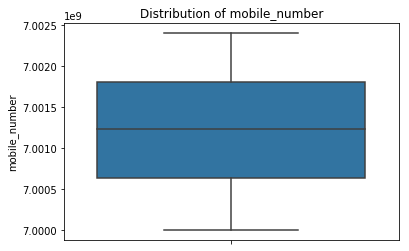

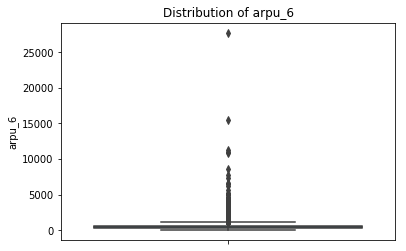

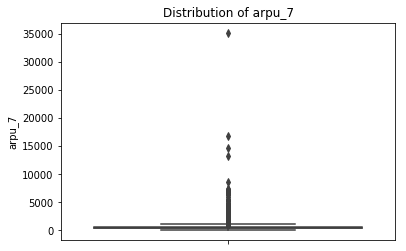

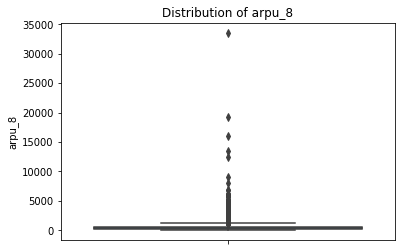

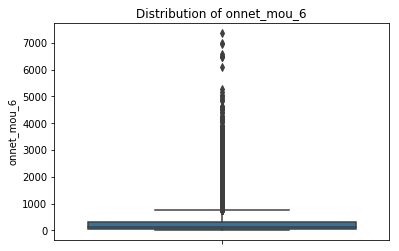

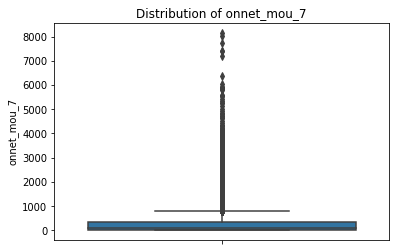

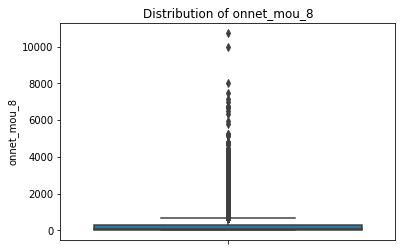

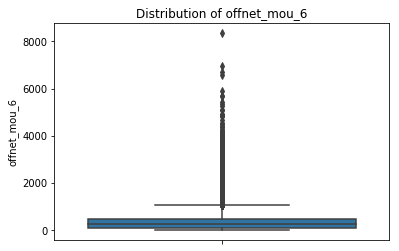

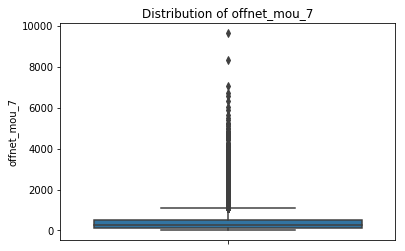

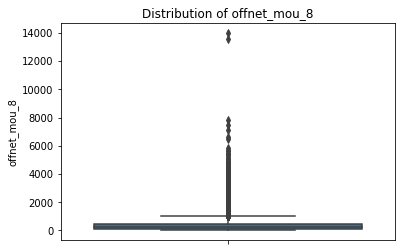

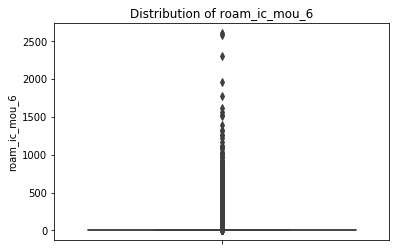

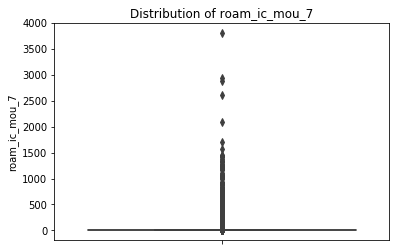

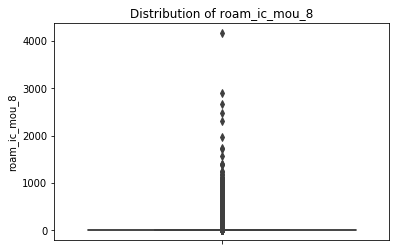

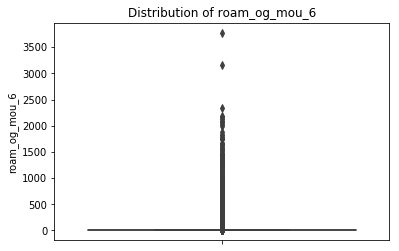

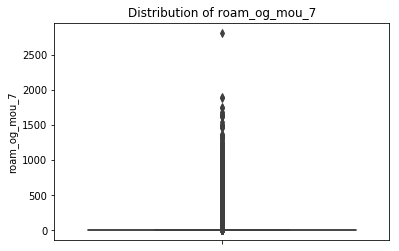

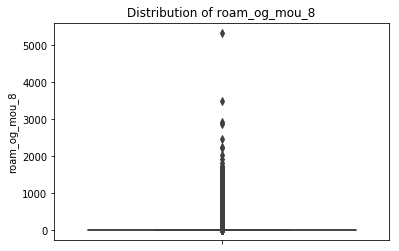

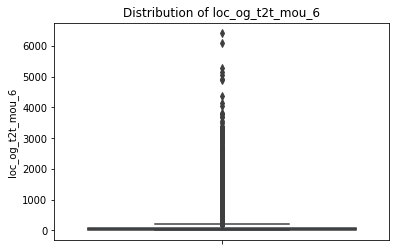

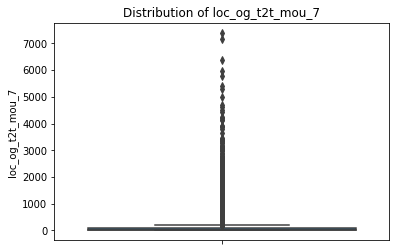

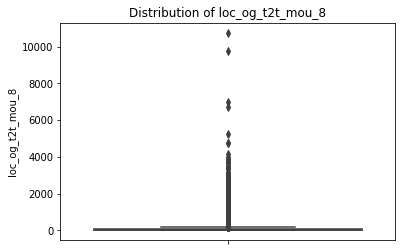

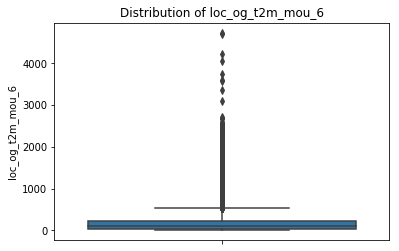

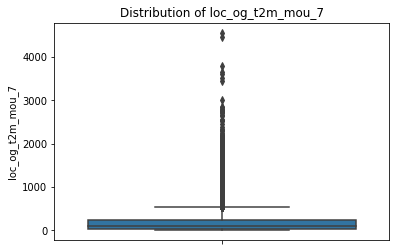

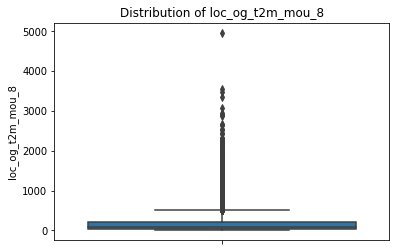

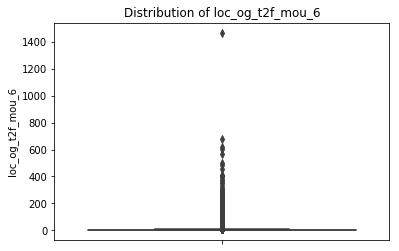

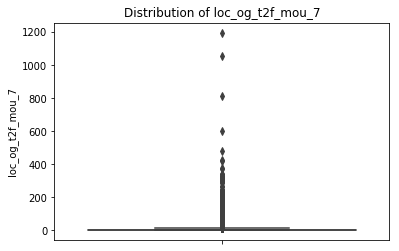

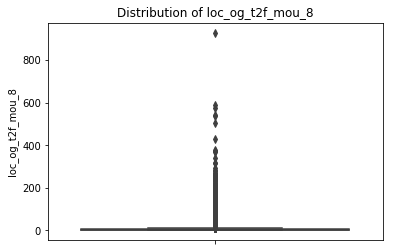

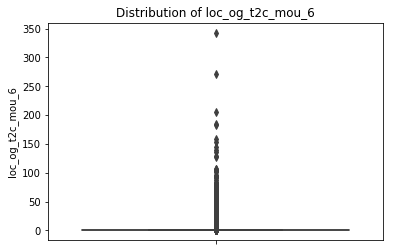

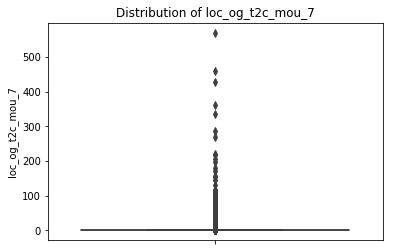

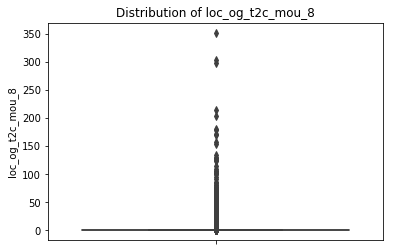

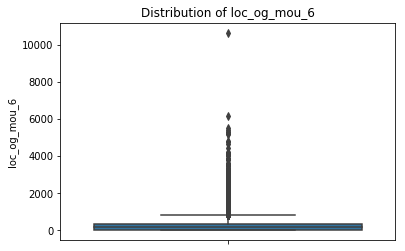

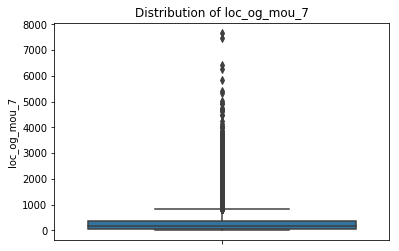

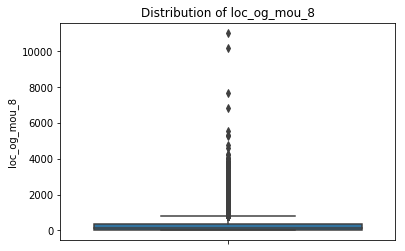

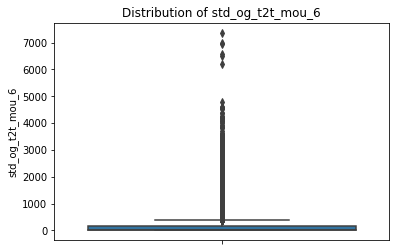

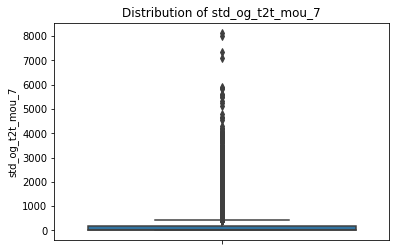

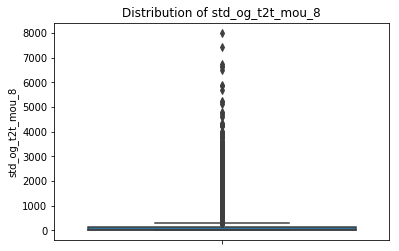

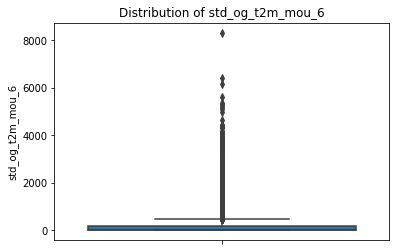

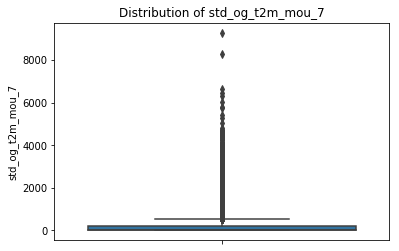

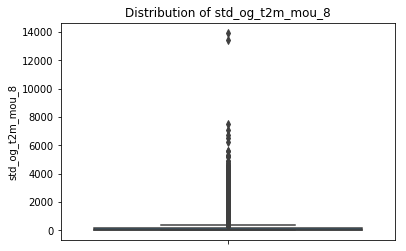

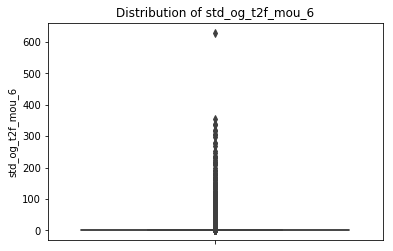

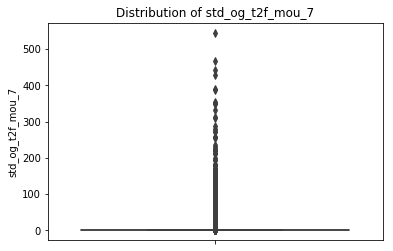

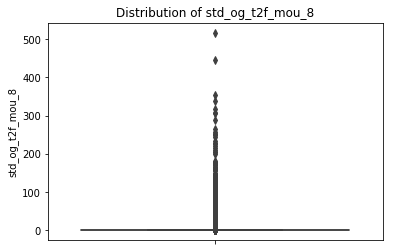

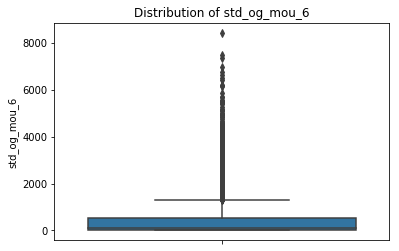

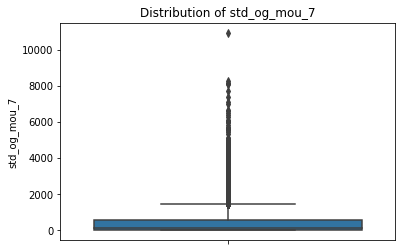

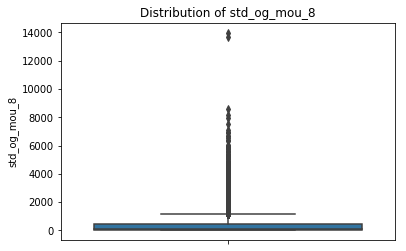

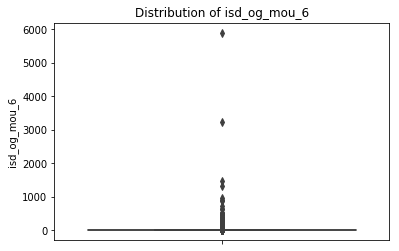

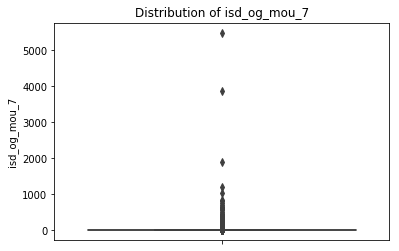

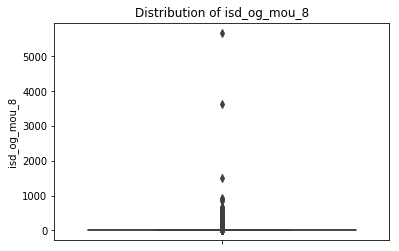

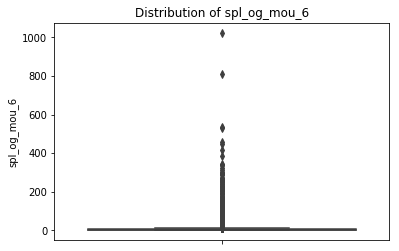

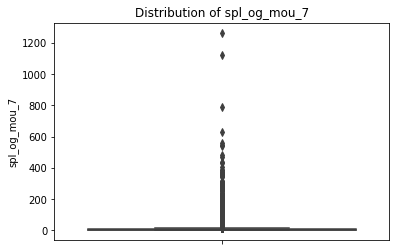

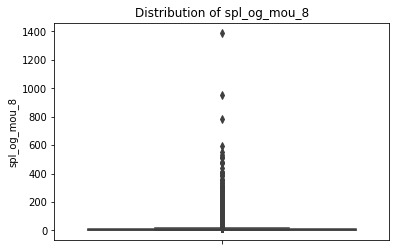

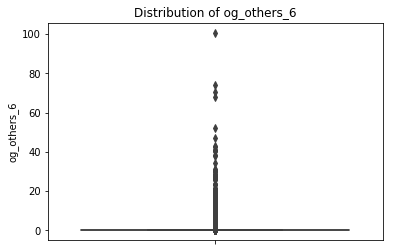

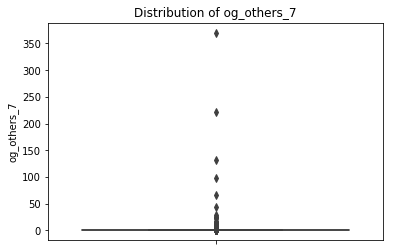

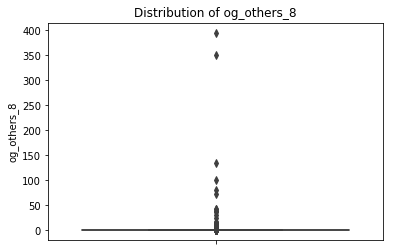

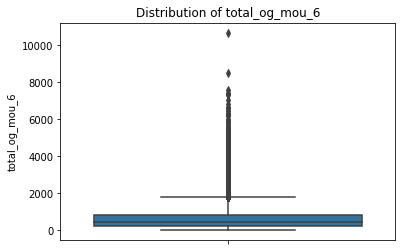

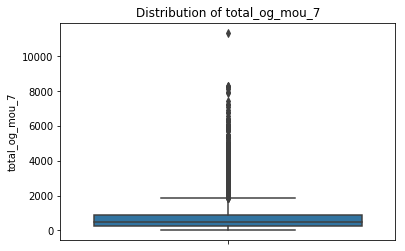

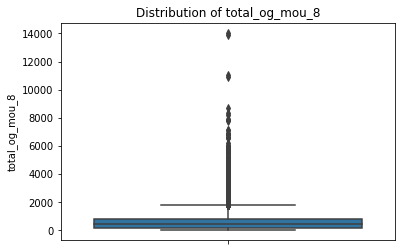

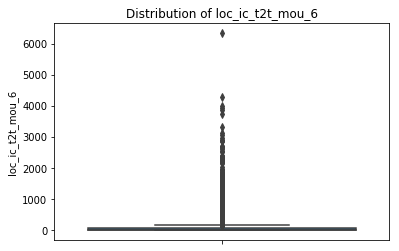

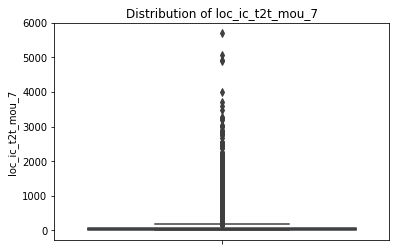

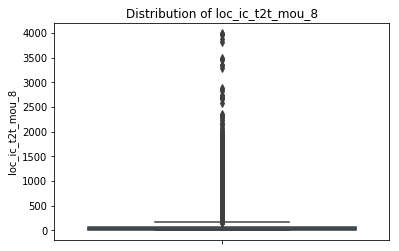

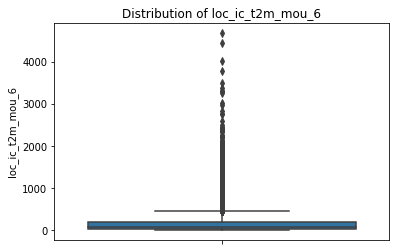

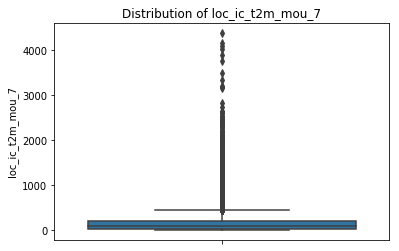

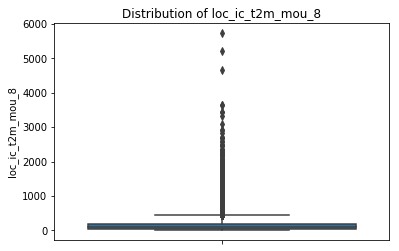

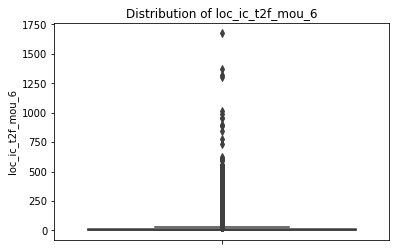

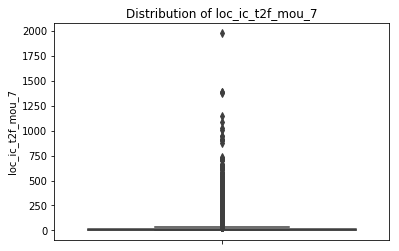

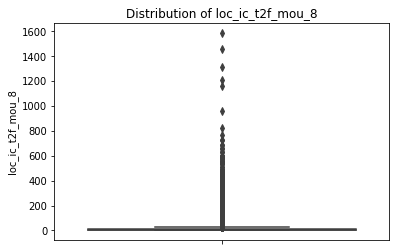

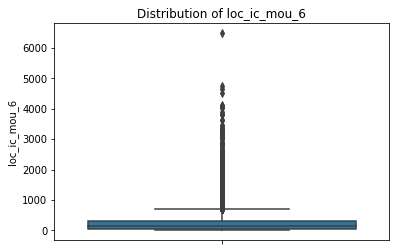

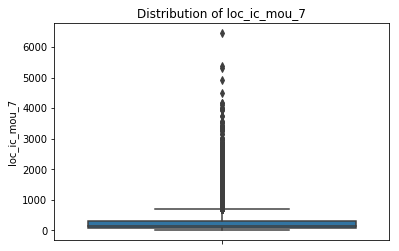

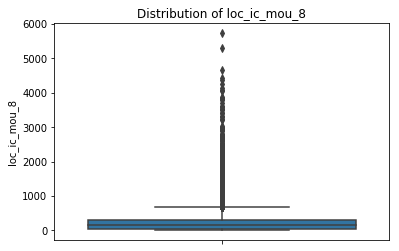

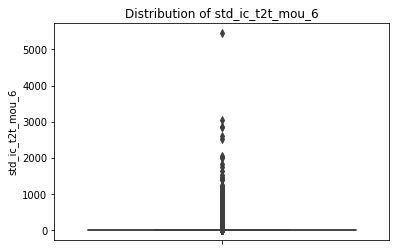

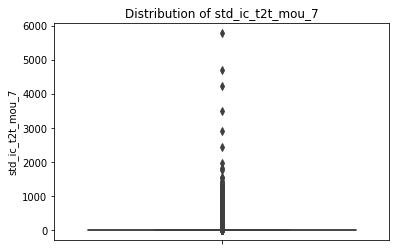

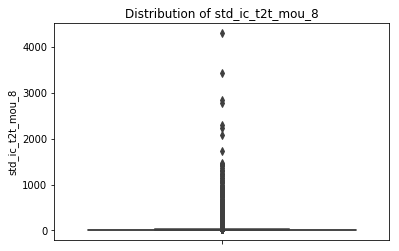

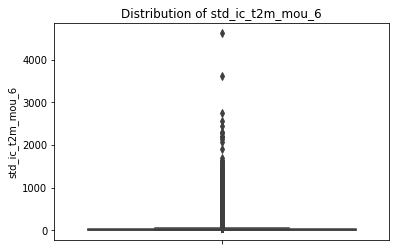

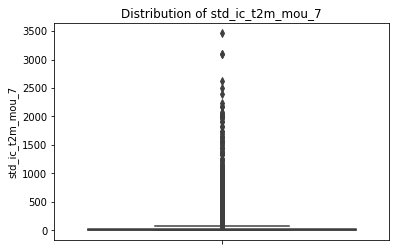

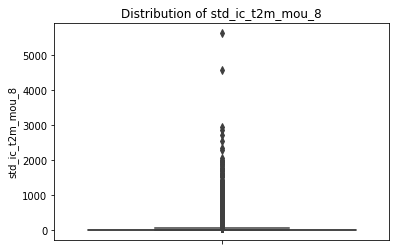

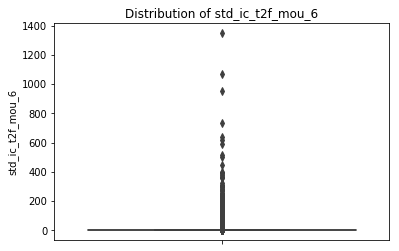

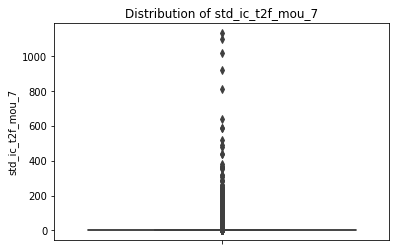

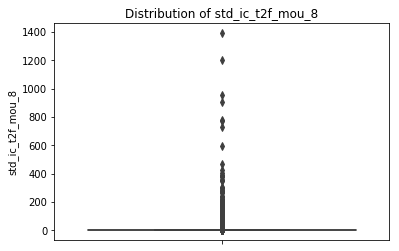

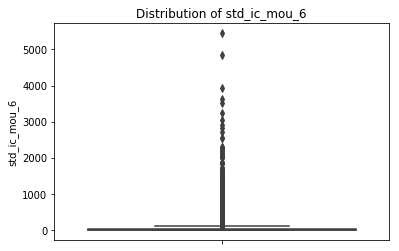

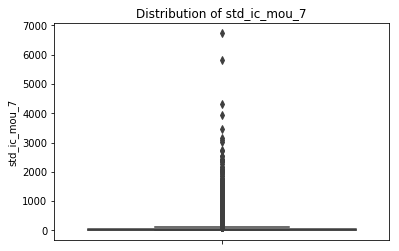

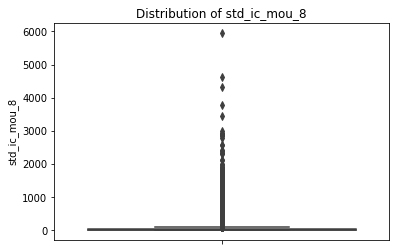

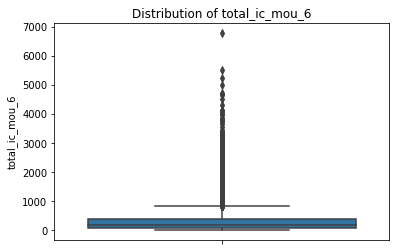

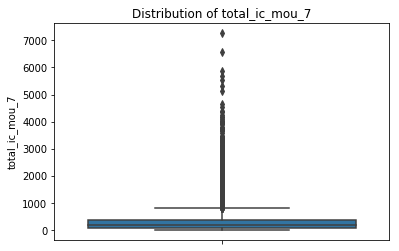

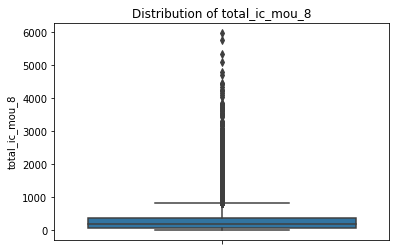

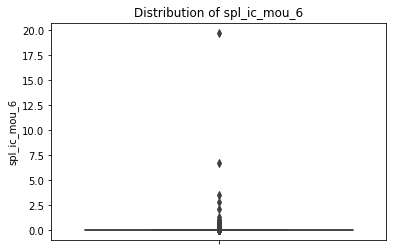

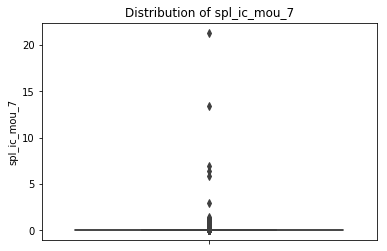

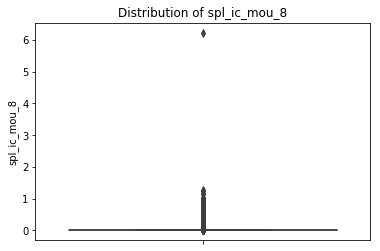

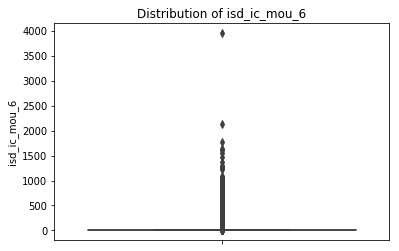

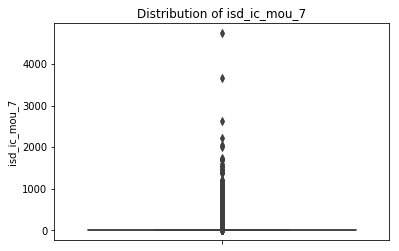

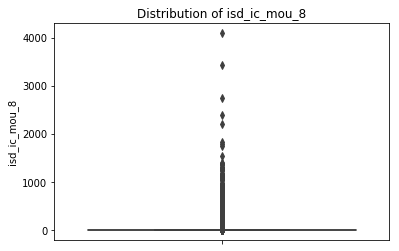

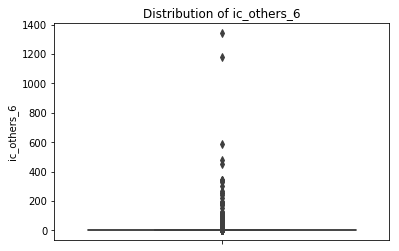

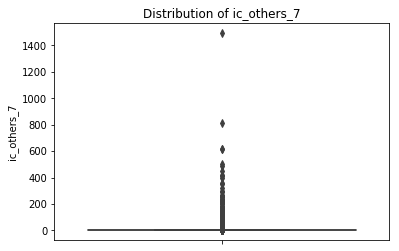

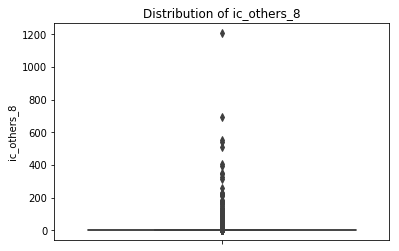

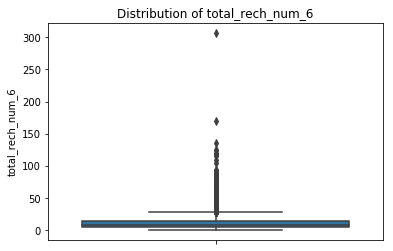

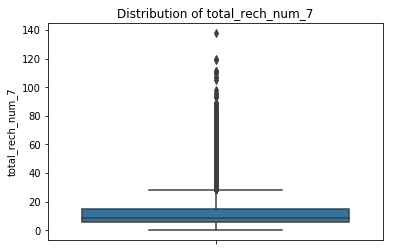

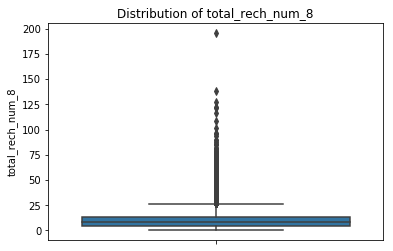

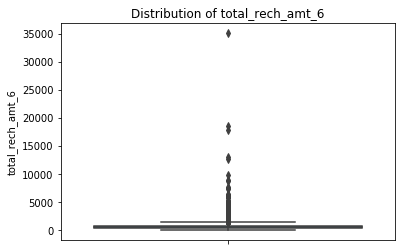

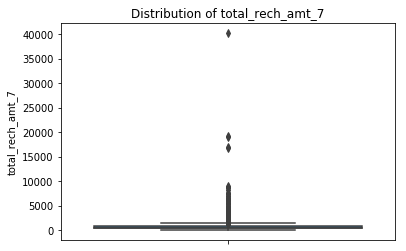

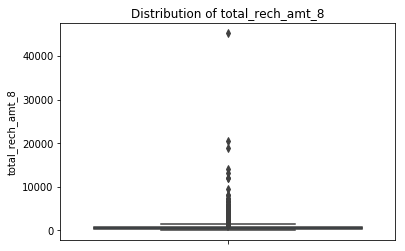

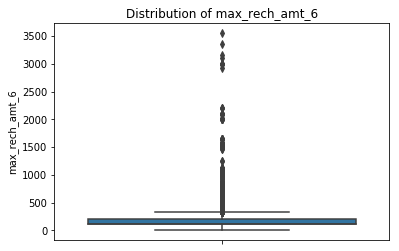

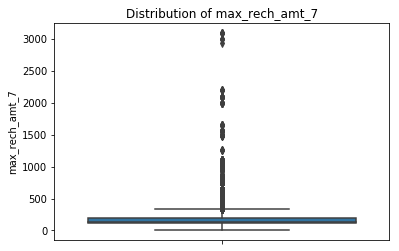

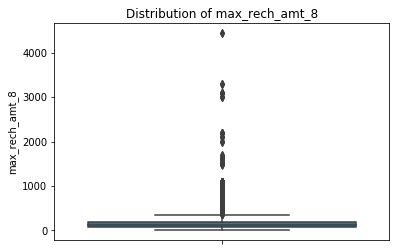

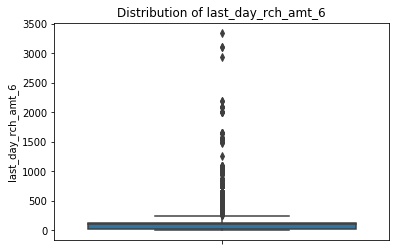

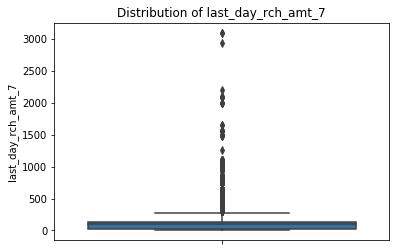

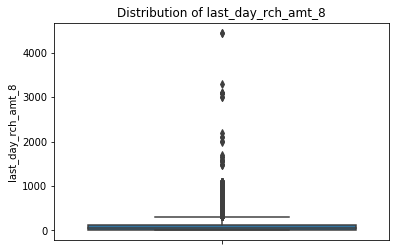

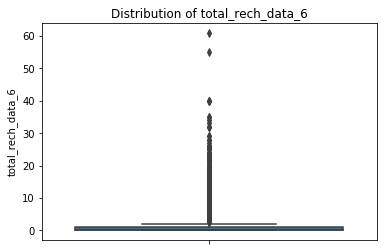

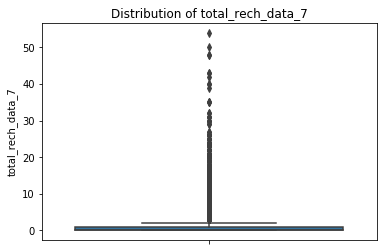

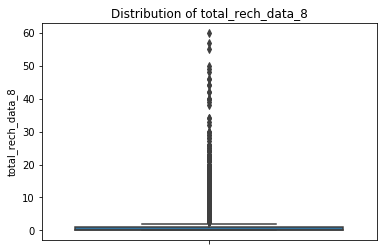

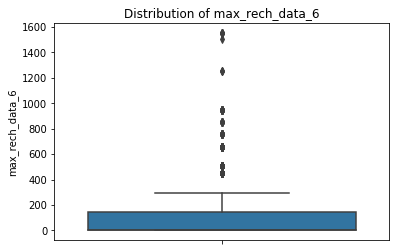

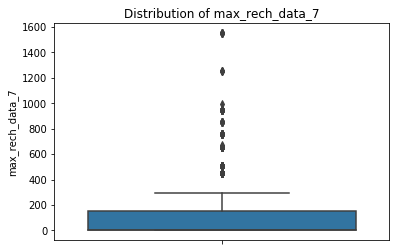

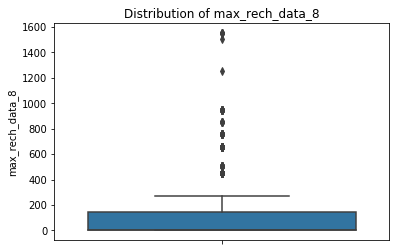

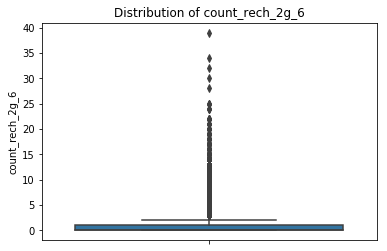

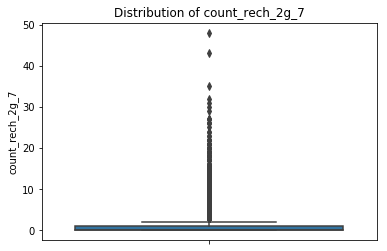

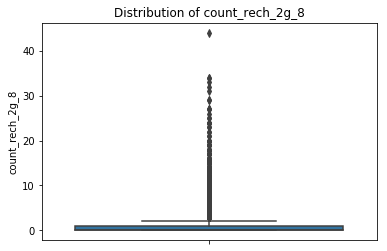

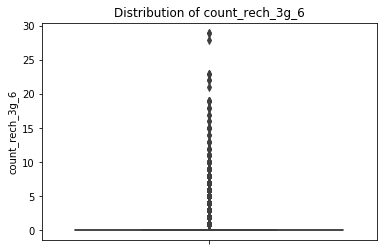

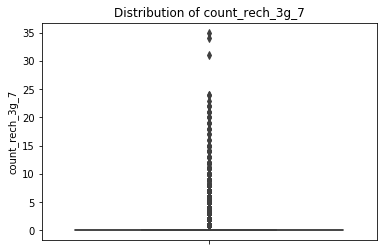

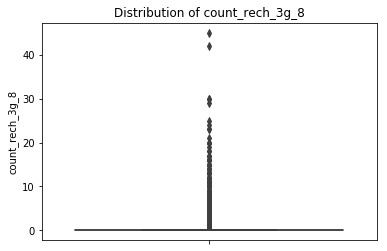

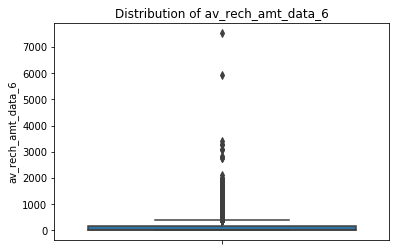

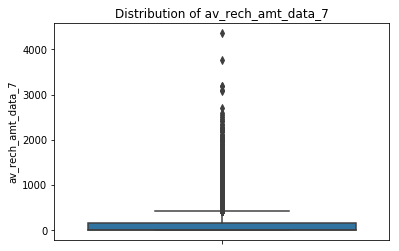

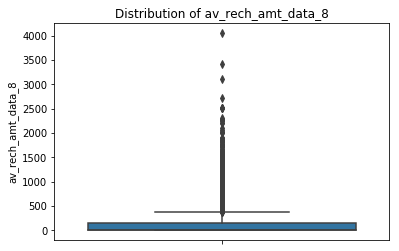

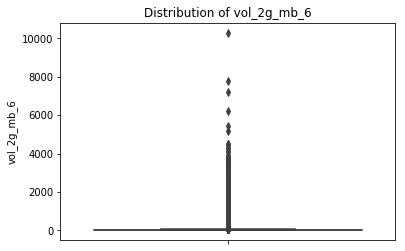

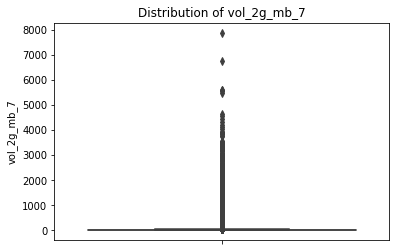

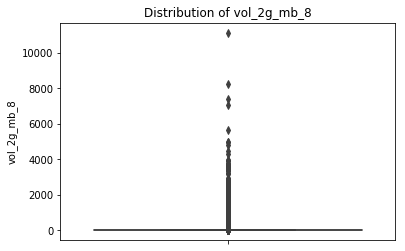

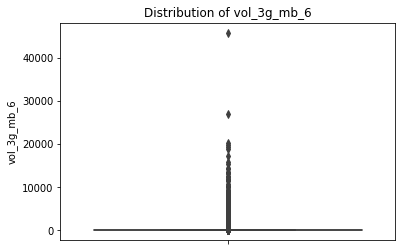

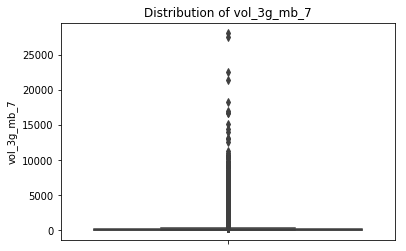

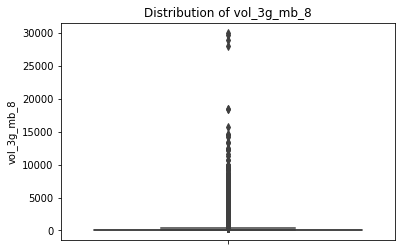

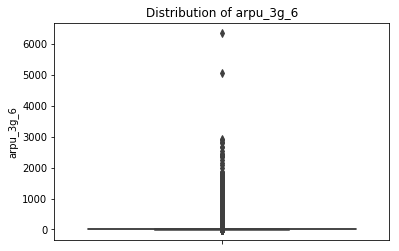

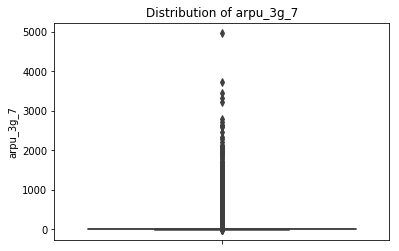

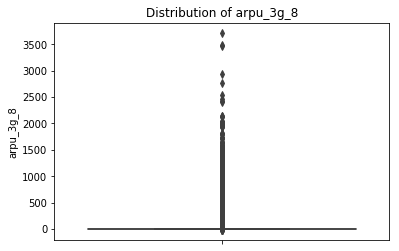

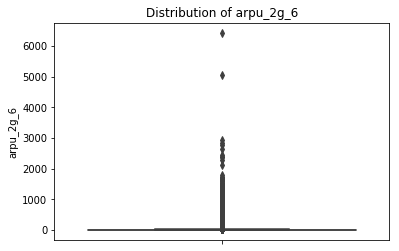

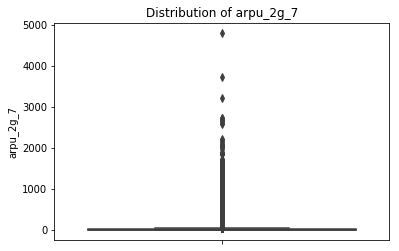

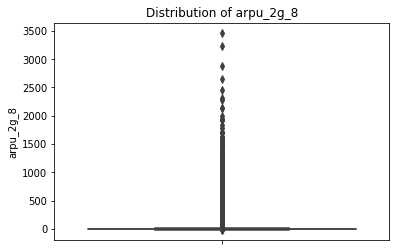

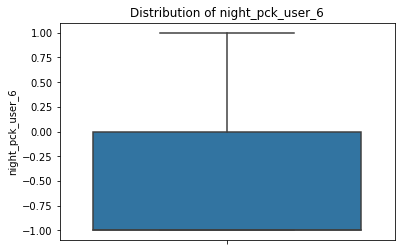

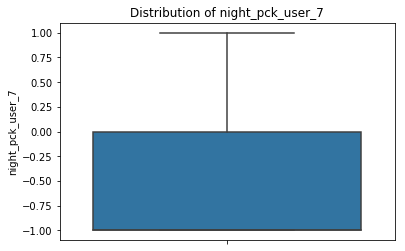

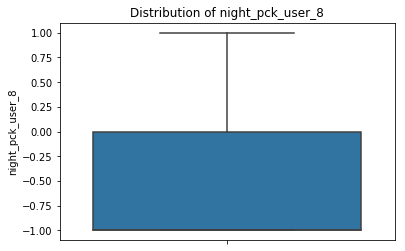

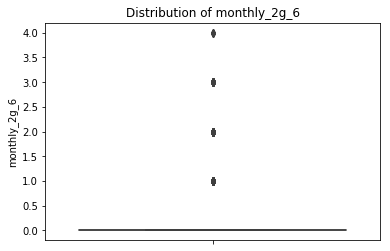

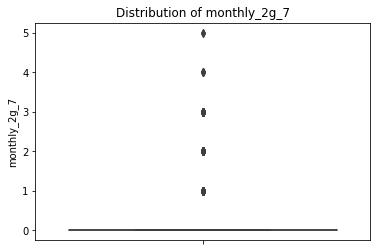

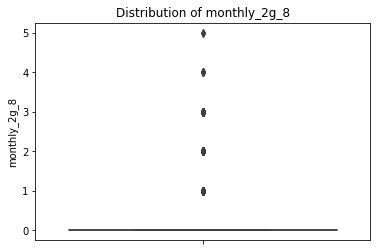

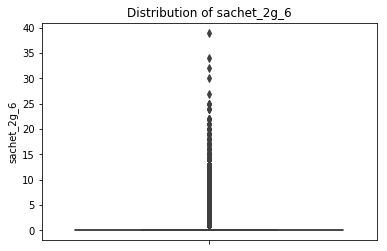

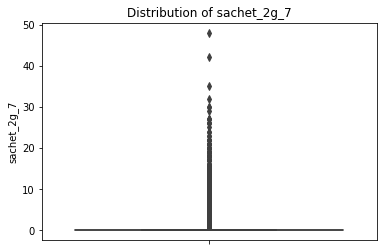

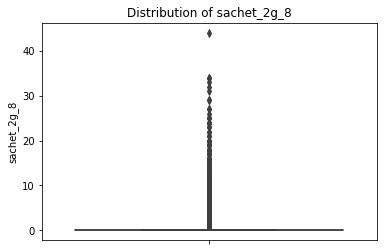

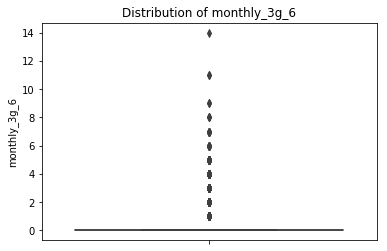

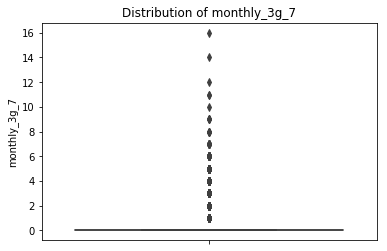

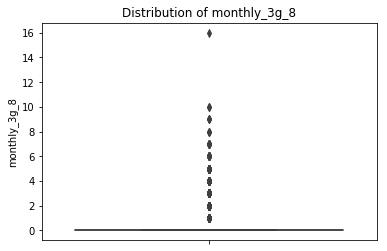

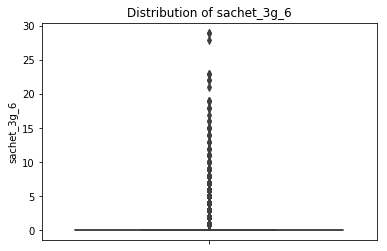

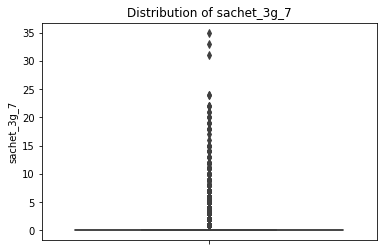

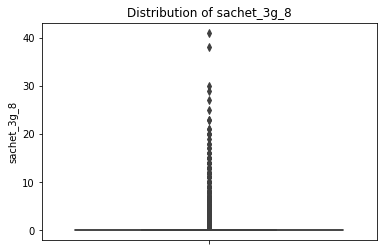

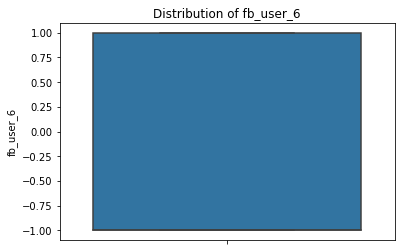

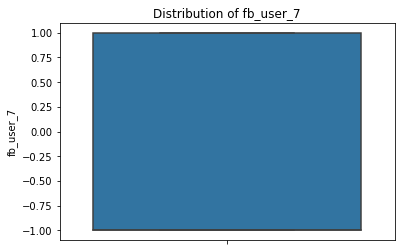

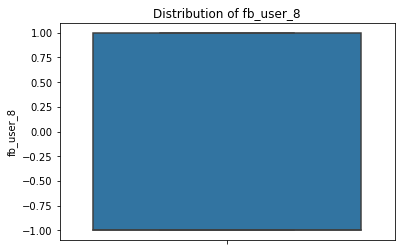

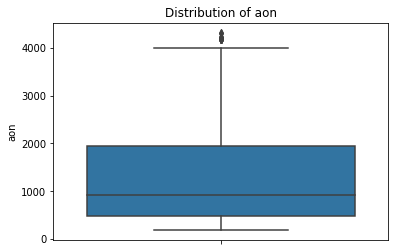

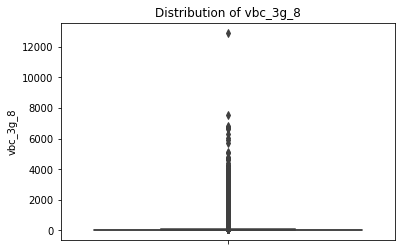

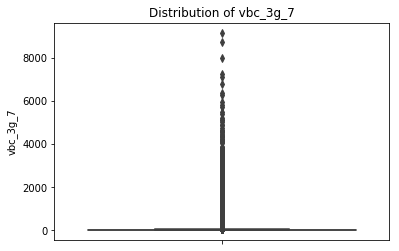

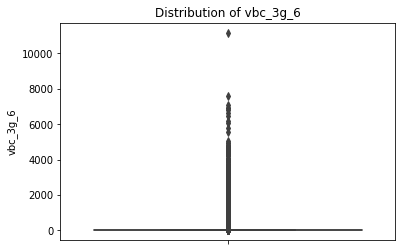

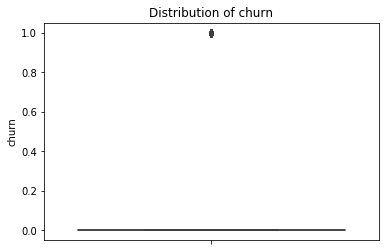

In [9]:
for numeric_variable in cleaned_df._get_numeric_data():
    plot_box(cleaned_df, numeric_variable)

# Univariate Analysis on Categorical Variables 

No Categorical variable so far, shall do after Deriving new variables

# Derive New Features
New features are derived and new Data Frame df is created, so that changes done for EDA & Visualization do not modify the shape of Pre Processed data for Model building

In [10]:
df = cleaned_df
## Derive new features based on the current features 
# Metric:average revenue per user 
# average revenue per user in a single column and split by average vs first two months average 
df['arpu_2mths'] = (df['arpu_6']+df['arpu_7'])/2
df['arpu_4mths'] = (df['arpu_6']+df['arpu_7']+df['arpu_8'])/3

In [11]:
# Metric:average revenue per user 
# average revenue per user in a single column and split by average vs first two months average 
df['avg_tot_rech_2mths'] = (df['total_rech_amt_6']+df['total_rech_amt_7'])/2
df['avg_tot_rech_4mths'] = (df['total_rech_amt_6']+df['total_rech_amt_7']+df['total_rech_amt_8'])/3

In [12]:
# Metric: age on network 
# Conversion of the number of months by 12
df['aon_years']=df['aon']/365
df['aon_years'] = df['aon_years'].astype(int)

In [13]:
def plot_for_seg_univariate(column_name,y_col_name,df_segment):
    plt.suptitle('Segmented Univariate Analysis (' + column_name + ')', fontsize=24)
    plt.rc("font", size=10)
    plt.figure(figsize=(20, 10))
    sns.barplot(x=df_segment.index, y=y_col_name, data=df_segment)
    plt.title('Age vs Average revenue ' + column_name)
    plt.xlabel(column_name,rotation=0, fontsize=20, labelpad=20)
    plt.xticks(rotation=45,fontsize=10)
    plt.ylabel('Age to Average revenue  ',rotation=90, fontsize=20, labelpad=20)
    plt.show()
    return

In [14]:
def plot_by_segment_numbins(column,new_bin_col_name,y_col_name,binval,showsize=10):
        df[new_bin_col_name] = pd.cut(df[column], binval)
        df_num_column_status=df.pivot_table(values=[y_col_name],index=[new_bin_col_name],aggfunc='mean')
        df_num_column_status.head(showsize)
        return df_num_column_status

In [15]:
def plot_by_grouped_barcharts(df_segment,label,showsize=10):
        colors = ['green', 'red']
        ax=df_segment.plot(kind='bar',figsize=(15,10),color=colors)
        ax.set_xlabel(label, fontsize=12)
        ax.set_ylabel("Churn", fontsize=12)
        plt.show()
        return 

In [16]:
def create_bin(column,new_bin_col_name,binval):
    df[new_bin_col_name] = pd.cut(df[column], binval)
    return df

               arpu_2mths
aon_group                
(6.6, 7.7]     559.954695
(8.8, 9.9]     559.998945
(7.7, 8.8]     565.525424
(5.5, 6.6]     569.081923
(4.4, 5.5]     569.446762
(-0.011, 1.1]  572.131442
(2.2, 3.3]     574.703067
(1.1, 2.2]     577.689306
(9.9, 11.0]    581.977747
(3.3, 4.4]     586.316275


<Figure size 432x288 with 0 Axes>

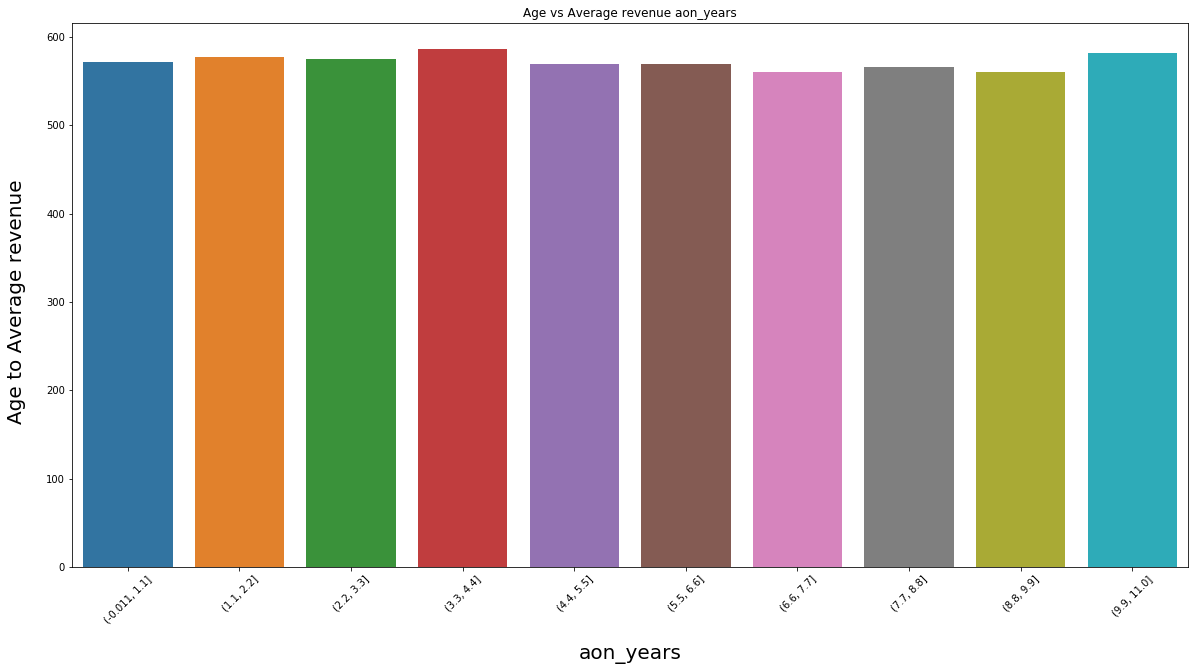

In [17]:
df2=plot_by_segment_numbins('aon_years','aon_group','arpu_2mths',10).sort_values(by='arpu_2mths',ascending=True)
print(df2)
plot_for_seg_univariate('aon_years','arpu_2mths',df2)

               arpu_4mths
aon_group                
(6.6, 7.7]     553.752184
(-0.011, 1.1]  555.428100
(8.8, 9.9]     558.233095
(7.7, 8.8]     559.878892
(1.1, 2.2]     561.342255
(2.2, 3.3]     561.351570
(4.4, 5.5]     562.153366
(5.5, 6.6]     564.744327
(3.3, 4.4]     577.930490
(9.9, 11.0]    582.948571


<Figure size 432x288 with 0 Axes>

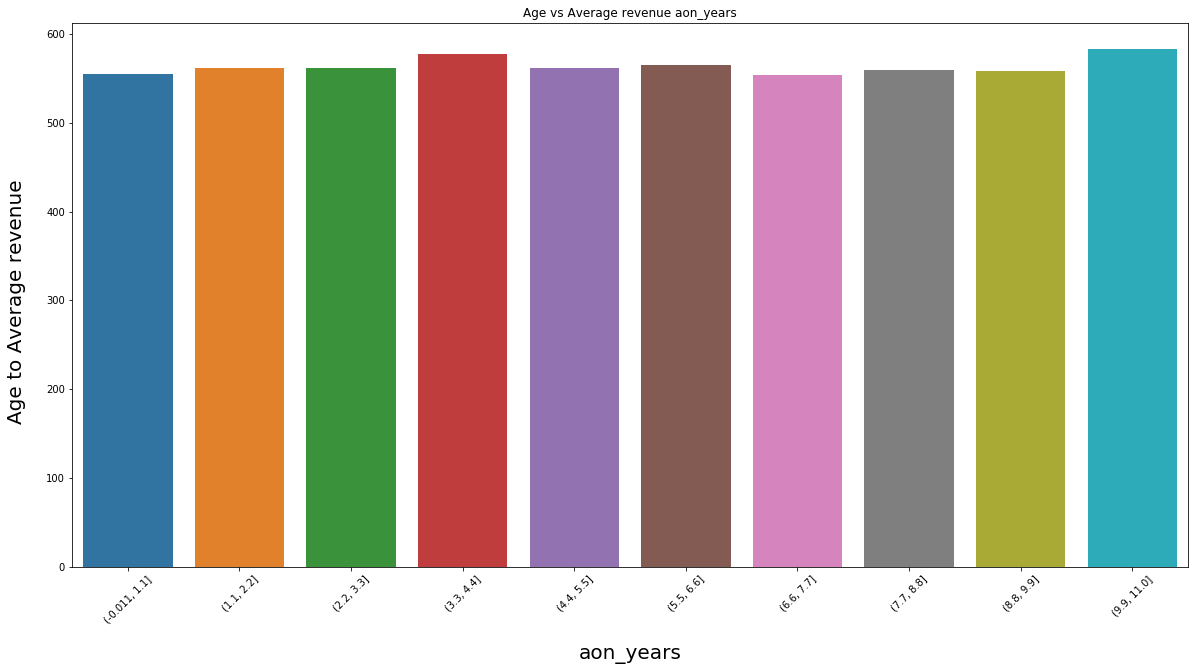

In [18]:
df2=plot_by_segment_numbins('aon_years','aon_group','arpu_4mths',10).sort_values(by='arpu_4mths',ascending=True)
print(df2)
plot_for_seg_univariate('aon_years','arpu_4mths',df2)

               arpu_2mths
aon_group                
(6.6, 7.7]     559.954695
(8.8, 9.9]     559.998945
(7.7, 8.8]     565.525424
(5.5, 6.6]     569.081923
(4.4, 5.5]     569.446762
(-0.011, 1.1]  572.131442
(2.2, 3.3]     574.703067
(1.1, 2.2]     577.689306
(9.9, 11.0]    581.977747
(3.3, 4.4]     586.316275


<Figure size 432x288 with 0 Axes>

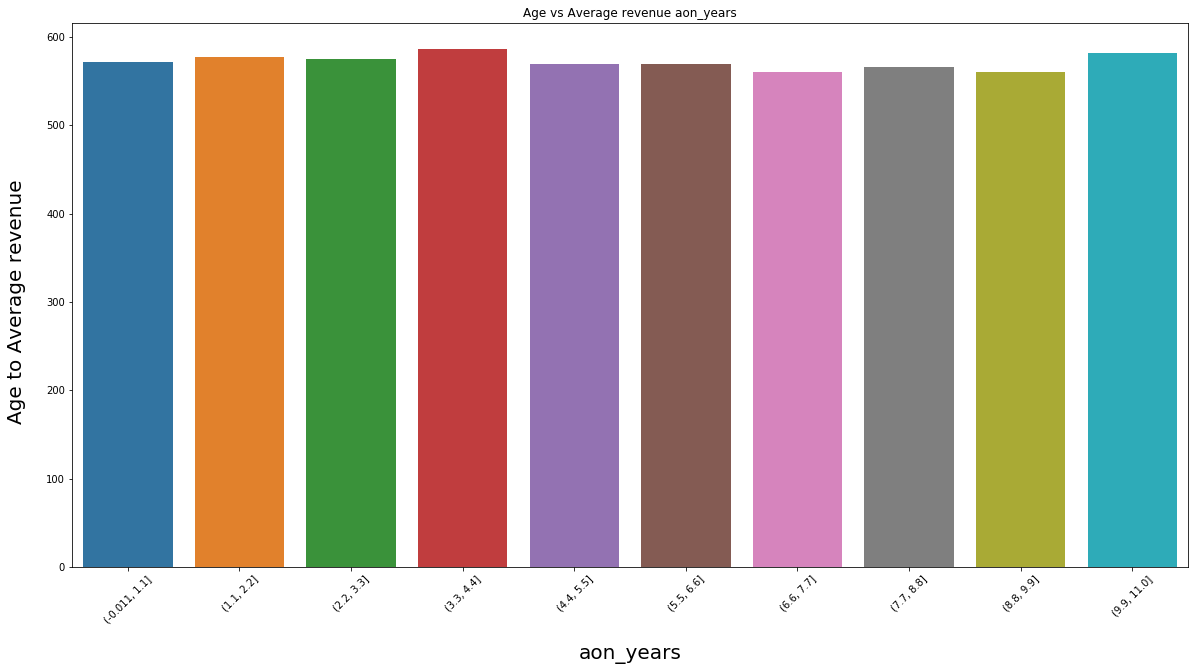

In [19]:
df2=plot_by_segment_numbins('aon_years','aon_group','arpu_2mths',10).sort_values(by='arpu_2mths',ascending=True)
print(df2)
plot_for_seg_univariate('aon_years','arpu_2mths',df2)

In [20]:
def plot_continuous_variable_boxPlot(df,param):
    
    '''Function plots a graphical Boxplot for the passed dataframe.

        Input:
            param: name of the parameter for which Box is plotted.
            df: pandas DataFrame'''
    
    not_churned_df=df[df.churn == 0]
    churned_df=df[df.churn  == 1]
    
    plt.figure(figsize=(20, 10)) 
    plt.subplot(1,2,1)
    sns.boxplot(y=not_churned_df[param])
    plt.title(param +' distribution for Not Churned ',fontsize=20)
    
    plt.subplot(1,2,2)
    sns.boxplot(y=churned_df[param])
    plt.title(param +' distribution for Churned ',fontsize=20)
    plt.show()

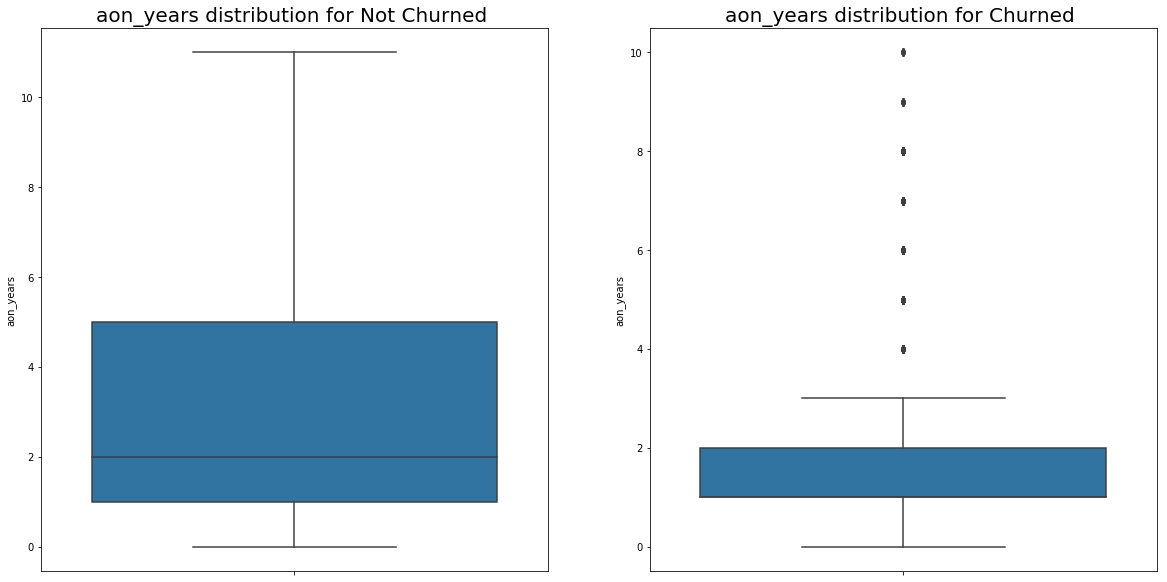

In [21]:
aon_df = df[['churn','aon_years']]
plot_continuous_variable_boxPlot(aon_df,'aon_years')

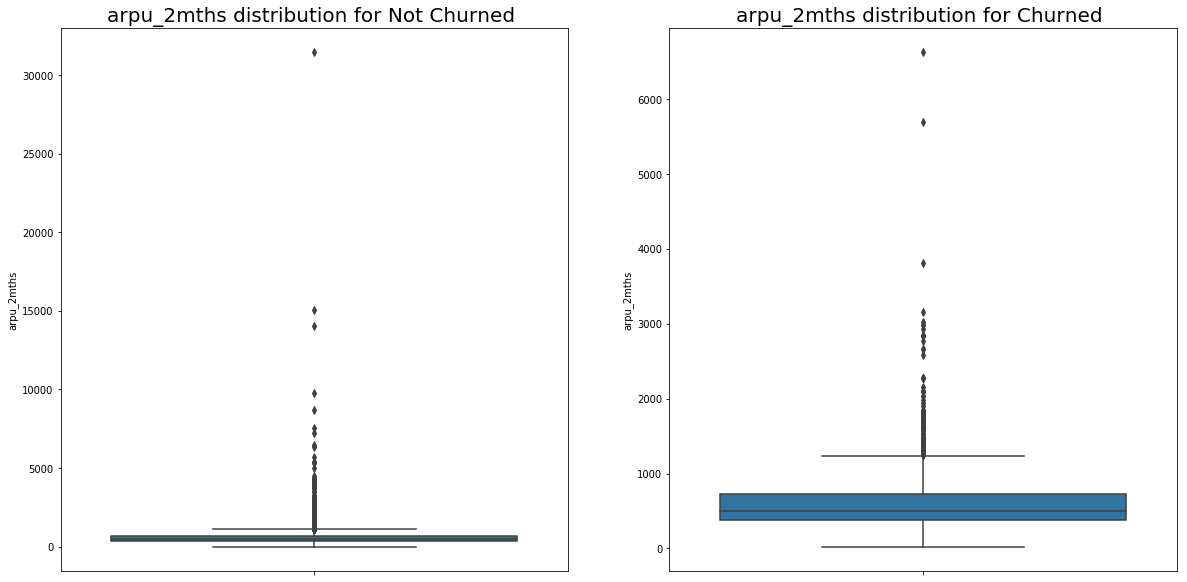

In [22]:
arpu_df = df[['churn','arpu_2mths']]
plot_continuous_variable_boxPlot(arpu_df,'arpu_2mths')

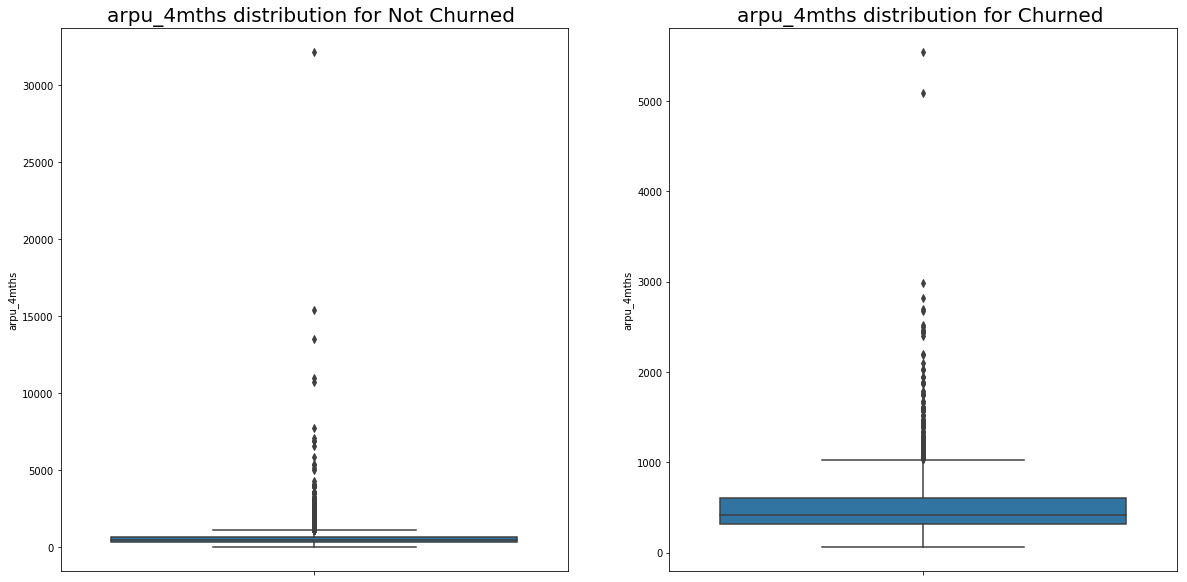

In [23]:
arpu_4df = df[['churn','arpu_4mths']]
plot_continuous_variable_boxPlot(arpu_4df,'arpu_4mths')

In [24]:
df['churn'].value_counts()

0    28468
1     1875
Name: churn, dtype: int64

In [25]:
df['aon_years'].value_counts()

1     7702
0     4859
2     4681
3     3103
6     2109
4     1997
7     1869
8     1565
5     1282
9      582
10     566
11      28
Name: aon_years, dtype: int64

churn              0     1
aon_group                 
(-0.011, 1.1]  11520  1041
(1.1, 2.2]      4306   375
(2.2, 3.3]      2949   154
(3.3, 4.4]      1918    79
(4.4, 5.5]      1241    41
(5.5, 6.6]      2043    66
(6.6, 7.7]      1813    56
(7.7, 8.8]      1527    38
(8.8, 9.9]       569    13
(9.9, 11.0]      582    12


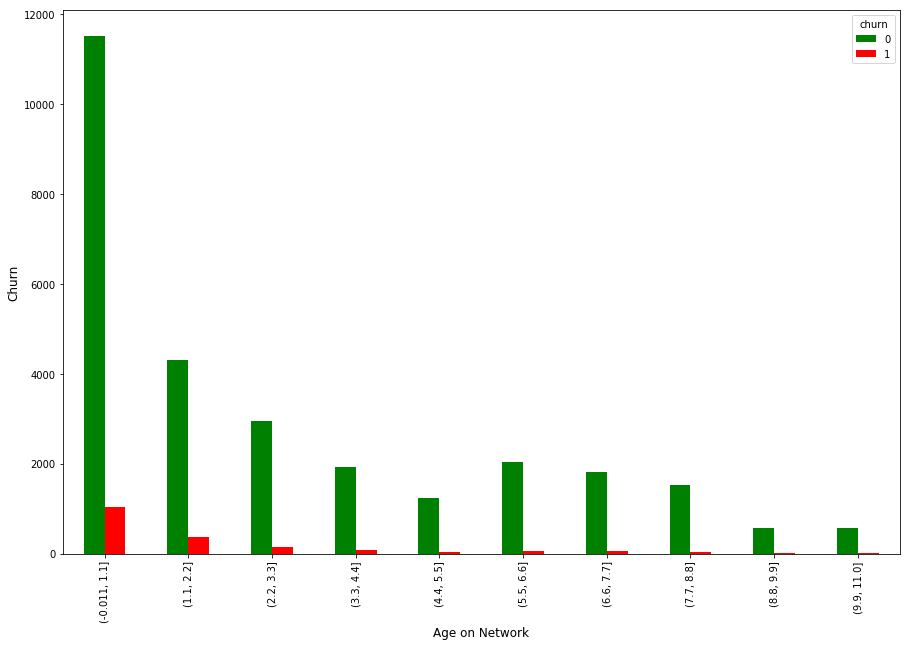

In [26]:
df_mod=pd.pivot_table(df, index='aon_group', columns=['churn'],values='aon', aggfunc='count')
print(df_mod)
plot_by_grouped_barcharts(df_mod,'Age on Network')

In [27]:
df['churn'].fillna(0, inplace=True)

churn                       0     1
arpu_group_2mths                   
(-26.453, 3148.328]     28435  1871
(3148.328, 6291.676]       24     3
(6291.676, 9435.024]        5     1
(9435.024, 12578.372]       1     0
(12578.372, 15721.72]       2     0
(28295.113, 31438.461]      1     0


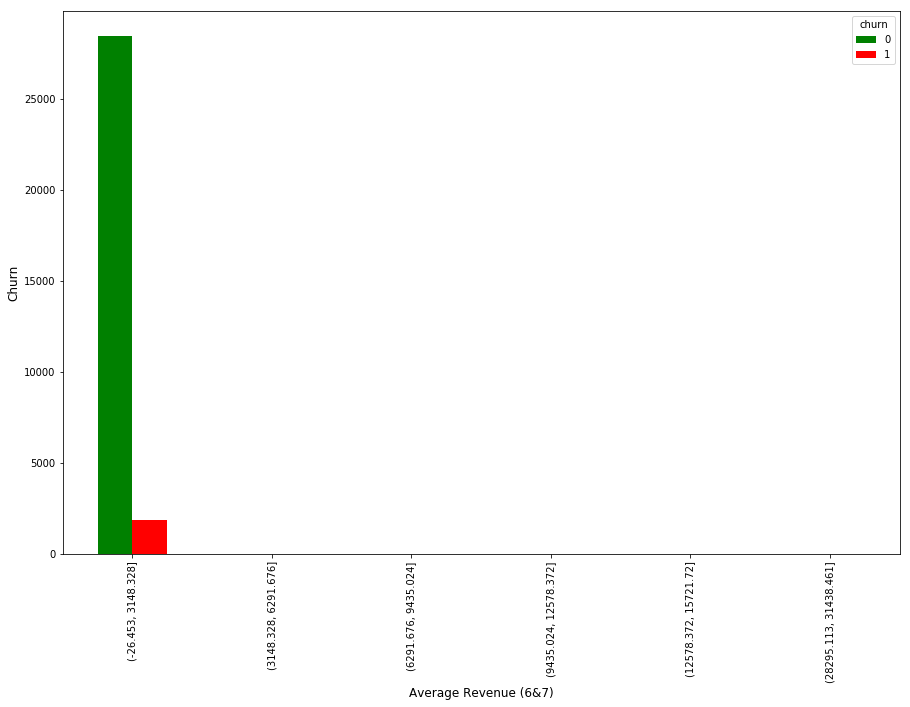

In [28]:
df=create_bin('arpu_2mths','arpu_group_2mths',10)
df_mod=pd.pivot_table(df, index='arpu_group_2mths', columns=['churn'],values='arpu_2mths', aggfunc = 'count',fill_value=0)
print(df_mod)
plot_by_grouped_barcharts(df_mod,'Average Revenue (6&7)')

churn                       0     1
arpu_group_4mths                   
(8.974, 6460.895]       28458  1875
(6460.895, 12880.717]       7     0
(12880.717, 19300.539]      2     0
(25720.36, 32140.182]       1     0


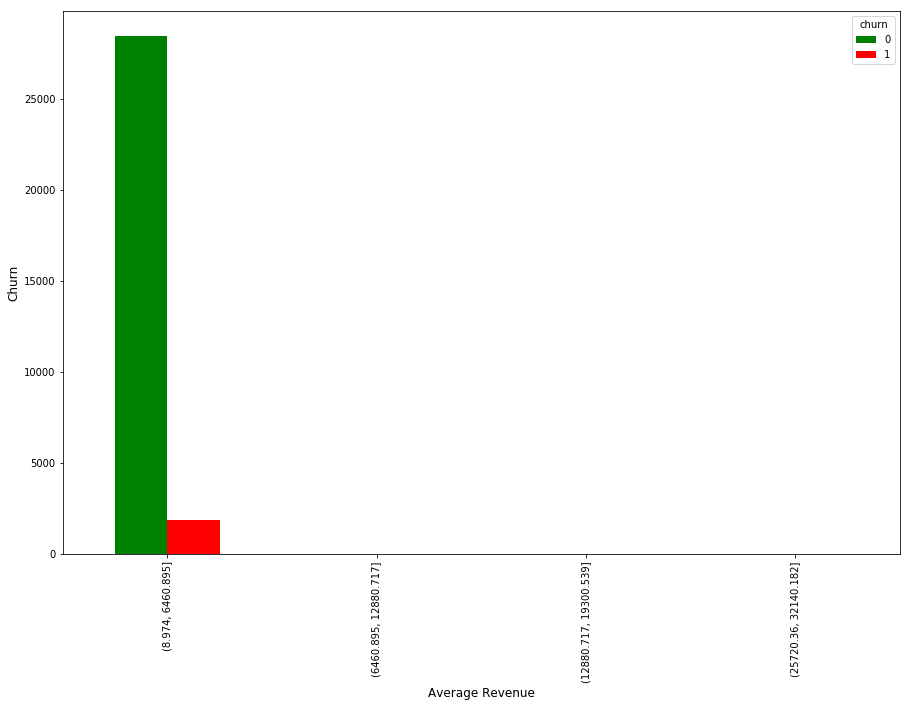

In [29]:
df=create_bin('arpu_4mths','arpu_group_4mths',5)
df_mod=pd.pivot_table(df, index='arpu_group_4mths', columns=['churn'],values='arpu_4mths', aggfunc = 'count',fill_value=0)
print(df_mod)
plot_by_grouped_barcharts(df_mod,'Average Revenue')

churn                         0     1
max_rech_amt_group_2mths             
(-3.1, 1033.333]          28379  1861
(1033.333, 2066.667]         83    12
(2066.667, 3100.0]            6     2


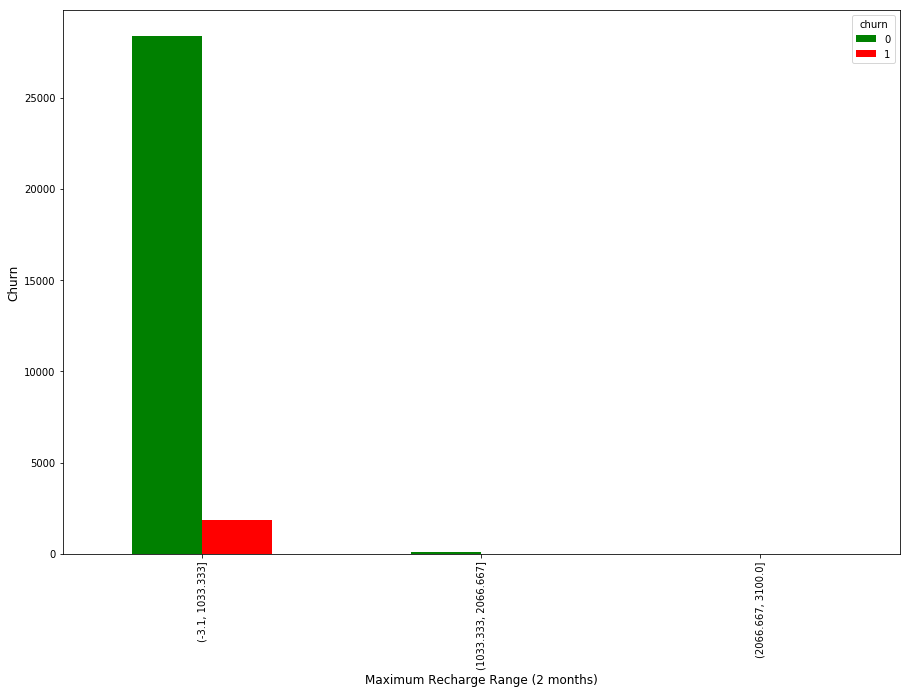

In [30]:
df['avg_max_rech_amt']=(df['max_rech_amt_6']+df['max_rech_amt_7'])/2
df=create_bin('avg_max_rech_amt','max_rech_amt_group_2mths',3)
df_mod=pd.pivot_table(df, index='max_rech_amt_group_2mths', columns=['churn'],values='avg_max_rech_amt', aggfunc = 'count',fill_value=0)
print(df_mod)
plot_by_grouped_barcharts(df_mod,'Maximum Recharge Range (2 months)')

churn                           0     1
total_rech_amt_group_2mths             
(-37.762, 7552.5]           28461  1873
(7552.5, 15105.0]               3     2
(15105.0, 22657.5]              3     0
(30210.0, 37762.5]              1     0


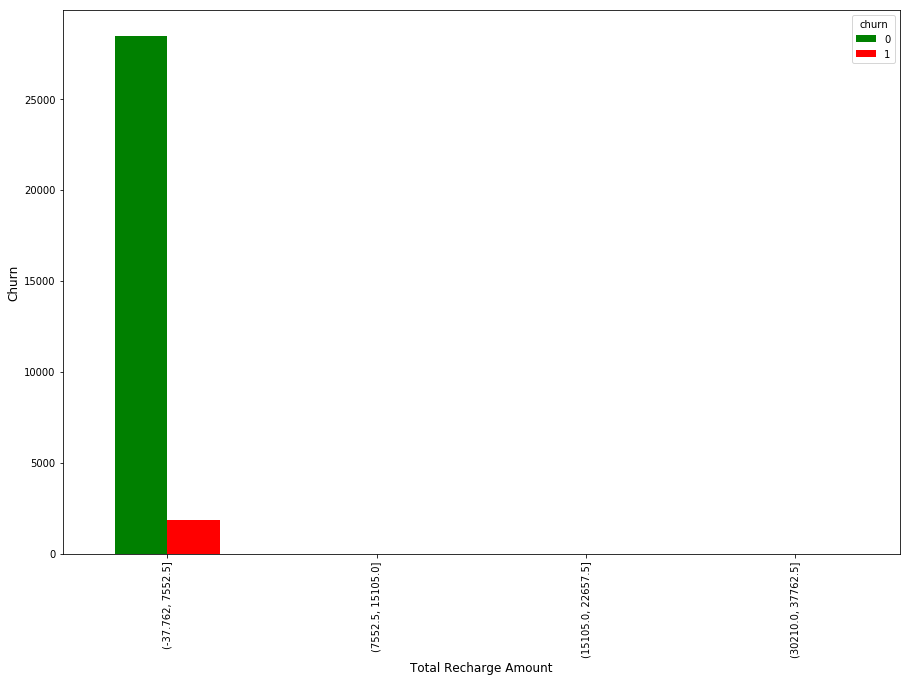

In [31]:
df['avg_total_rech_amt']=(df['total_rech_amt_6']+df['total_rech_amt_7'])/2
df=create_bin('avg_total_rech_amt','total_rech_amt_group_2mths',5)
df_mod=pd.pivot_table(df, index='total_rech_amt_group_2mths', columns=['churn'],values='avg_total_rech_amt', aggfunc = 'count',fill_value=0)
print(df_mod)
plot_by_grouped_barcharts(df_mod,'Total Recharge Amount')

# Bivariate Analysis

In [32]:
df.select_dtypes(exclude=['object'])

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
0         7000842753   197.385   214.816   213.803         0.00         0.00   
7         7000701601  1069.180  1349.850  3171.480        57.84        54.68   
8         7001524846   378.721   492.223   137.362       413.69       351.03   
13        7002191713   492.846   205.671   593.260       501.76       108.39   
16        7000875565   430.975   299.869   187.894        50.51        74.01   
17        7000187447   690.008    18.980    25.499      1185.91         9.28   
21        7002124215   514.453   597.753   637.760       102.41       132.11   
24        7001125315   422.050   359.730   354.793       124.19        55.19   
33        7000149764   977.020  2362.833   409.230         0.00         0.00   
38        7000815202   363.987   486.558   393.909       248.99       619.96   
41        7000721289   482.832   425.764   229.769        86.39       118.88   
48        7000294396  1873.271   575.927   179.218      2061.69       881.43   
53        7002188521   978.077  1141.296   706.020       135.14       119.59   
56        7002180748   452.624   320.548   368.807        34.46        43.11   
57        7001682585  1201.298   687.704   602.052        61.23         7.39   
60        7000955945   410.261   430.205   289.228        62.24        85.68   
61        7000152517   565.516   390.307   430.911       178.41       226.81   
67        7000800341   218.818   386.515   386.502         0.00         0.00   
69        7002393996   809.518   794.775    33.060       181.63       257.06   
73        7002402996  2401.829  1873.764   722.368      2020.84      3220.46   
74        7001532600   324.449   382.389   350.360       381.23       635.28   
77        7001328263    30.000    82.378   674.950         0.00        34.23   
87        7001728145   623.635   712.818   560.995       162.68       133.49   
92        7001606600   465.794   530.596   463.903       178.46        92.96   
96        7001480390   676.999   786.560   377.488       113.24       360.04   
97        7000589828   374.863   294.023   183.043       433.59       415.66   
101       7001746121   512.524   402.001  1144.254       314.66       197.01   
102       7001631060   451.375   324.314   324.050        30.43        24.96   
103       7002236431   883.401  1082.027   759.027       253.98       287.11   
105       7000208415   659.587   398.875   621.127       995.39       453.39   
...              ...       ...       ...       ...          ...          ...   
99893     7001438347   547.602   398.135   408.193       326.14       205.31   
99896     7002362186   504.271   436.843   344.496       162.18       127.01   
99899     7001632563   976.749   777.884  1012.579       892.39      1250.34   
99902     7002142544   441.209   316.964   313.691        59.13        14.11   
99904     7000649339   435.504   515.231   231.290       520.94       562.68   
99921     7000157295    79.066   511.262   393.454         8.88        29.91   
99922     7001602180   458.049   681.324   332.863         4.56        26.93   
99923     7000571771   919.526   777.112   813.973         7.79        14.33   
99924     7001581208   457.827   416.103   389.400       105.11       103.01   
99925     7000877443   137.643   905.596   718.777        74.08      1396.44   
99927     7001570091   474.220   420.099   513.224        35.53        40.13   
99929     7002128793   418.140   766.583  1053.680        95.89        82.86   
99931     7001904289   897.341   176.181   468.485        22.38       103.51   
99932     7000018772   419.691   361.736   290.221       275.59       495.29   
99935     7002109027   552.795   267.650   531.254        94.31        64.16   
99937     7000534033   351.397   429.744   312.262       530.53       696.33   
99939     7001631916   398.308   834.643   203.506       553.84      1293.43   
99941     7002281862   565.598   588.814   702.341       326.08       335.38   
99943  

No handles with labels found to put in legend.


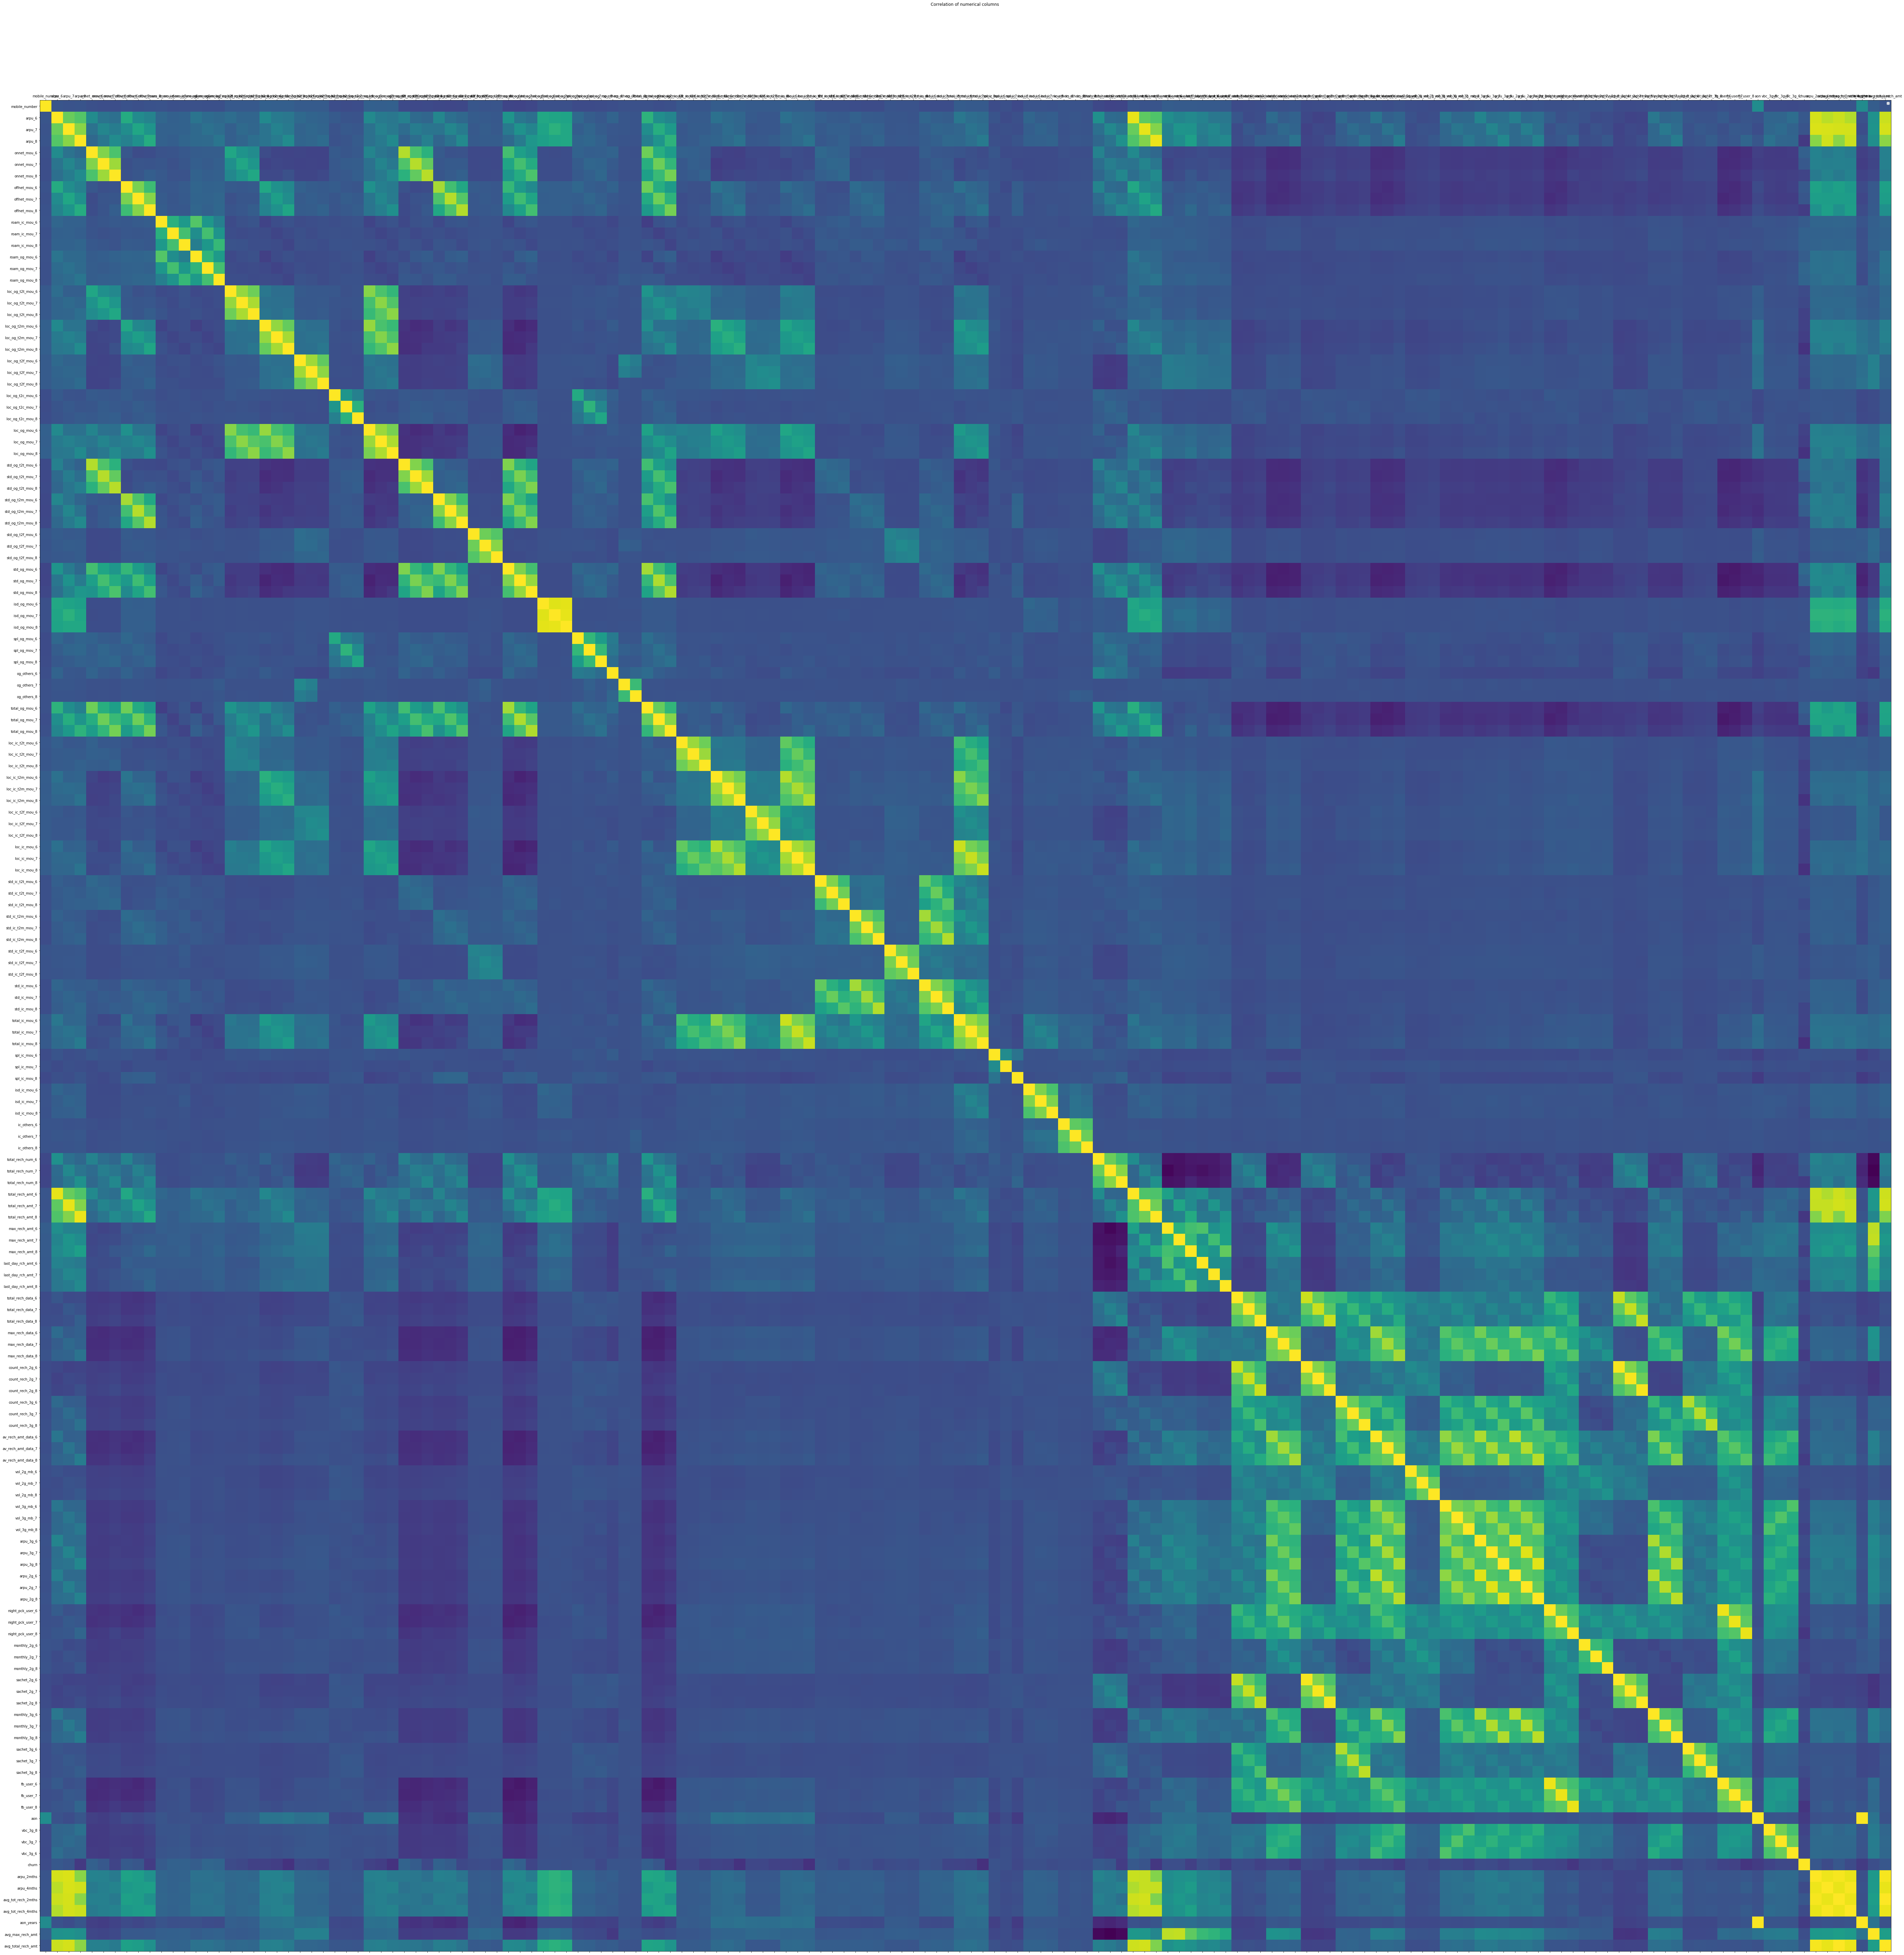

In [33]:
# Let's see the correlation matrix 
upper = df._get_numeric_data().corr()

# Select upper triangle of correlation matrix
#upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

#upper.sort_values().drop_duplicates()
#upper=corr.unstack().sort_values().drop_duplicates()

# Find index of feature columns with correlation greater than 0.95

fig, ax = plt.subplots(figsize=(120, 100))
ax.matshow(upper)
plt.xticks(range(len(upper.columns)), upper.columns)
plt.yticks(range(len(upper.columns)), upper.columns)
ax.legend()
plt.title('Correlation of numerical columns ')
plt.show()

Bivariate and Segmented Univariate Analysis to be done by considering the columns in batches due to High dimensionality. Skipping batch wise analysis for now.

# Building And Evaluating Model for Predicting Churn Customers

In [34]:
cleaned_df = ( DataCleaner()
    .import_and_describe_data()
    .drop_single_value_columns()
    .fix_column_names()
    .tag_Churners()
    .filter_High_Value_Customers()
    .remove_negative_arpu() # Remove EDA identified negative values in ARPU
   #.drop_na()
    .impute_night_pack_user()       
    .impute_fb_user()  
    .fill_na()
    .drop_mobile_number_col()
).df

# PCA
## Data Preparation for PCA
### Handling Categorical variables for PCA

In [35]:
PCA_df=df._get_numeric_data()

In [36]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = PCA_df.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = PCA_df['churn']

y.head()

0     1
7     1
8     0
13    0
16    0
Name: churn, dtype: int32

In [37]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [38]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train,y_train)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [39]:
Scaled_Xtrain=X_scaler.transform(X_train,y_train)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:765: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [40]:
from sklearn.linear_model import LinearRegression

# Representing LinearRegression as lr(Creating LinearRegression Object)
lr = LinearRegression()

# Fit the model using lr.fit()
lr.fit(Scaled_Xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [41]:
X_test_scaler = StandardScaler().fit(X_test,y_test)
Scaled_Xtest=X_test_scaler.transform(X_test,y_test)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:765: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [42]:
y_pred = lr.predict(Scaled_Xtest)

In [43]:
y_test.unique()

array([0, 1], dtype=int64)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
print(mse)

2.325922459575391e+19


In [45]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

-4.008649198152941e+20


In [46]:
Scaled_Xtrain.shape

(21240, 158)

In [47]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=100)

In [48]:
#Doing the PCA on the train data
pca.fit(Scaled_Xtrain)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='randomized', tol=0.0, whiten=False)

In [49]:
pca.components_

array([[ 4.99224844e-02,  5.18279597e-02,  5.61621629e-02, ...,
         1.49249599e-02,  9.24211761e-02,  5.23970022e-02],
       [ 1.93078044e-01,  1.99116108e-01,  1.93567726e-01, ...,
         1.59680158e-02,  9.31160217e-02,  2.10639343e-01],
       [ 6.28130932e-02,  8.07038384e-02,  6.54251232e-02, ...,
        -1.03605683e-01, -3.65319431e-02,  7.66448368e-02],
       ...,
       [-0.00000000e+00,  2.51929850e-16,  1.93798913e-02, ...,
         9.72258298e-17, -9.51410850e-02, -5.32665418e-02],
       [-0.00000000e+00, -6.76841111e-17,  7.32229308e-08, ...,
        -1.58400063e-17, -7.22364540e-07, -7.07106879e-01],
       [-4.50594819e-01, -4.93845365e-01, -1.40923237e-01, ...,
         4.03323208e-17,  7.06466136e-16,  1.35828848e-15]])

In [50]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1       PC2      Feature
0  0.049922  0.193078       arpu_6
1  0.051828  0.199116       arpu_7
2  0.056162  0.193568       arpu_8
3 -0.052616  0.086381  onnet_mou_6
4 -0.054195  0.094546  onnet_mou_7

In [51]:
pca.explained_variance_ratio_

array([1.22470575e-01, 1.01083017e-01, 7.02351235e-02, 5.40968243e-02,
       3.93507011e-02, 3.67707209e-02, 2.90319380e-02, 2.66052502e-02,
       2.40184201e-02, 2.18572461e-02, 2.04743453e-02, 1.83512329e-02,
       1.79796701e-02, 1.77899685e-02, 1.69322564e-02, 1.60681100e-02,
       1.59088102e-02, 1.45377560e-02, 1.28800709e-02, 1.24896318e-02,
       1.17741105e-02, 1.11772556e-02, 1.09454550e-02, 1.05637290e-02,
       9.95339735e-03, 9.69613613e-03, 9.35548647e-03, 8.60979548e-03,
       8.35298768e-03, 8.02192427e-03, 7.57413973e-03, 7.37492760e-03,
       6.98396608e-03, 6.85904594e-03, 6.10444461e-03, 5.99990787e-03,
       5.90446510e-03, 5.78936901e-03, 5.74111403e-03, 5.67199995e-03,
       5.22127679e-03, 5.08866954e-03, 5.04407799e-03, 4.83336309e-03,
       4.78539069e-03, 4.68293411e-03, 4.58451221e-03, 4.52422172e-03,
       4.31646605e-03, 4.06289798e-03, 3.84226135e-03, 3.74897762e-03,
       3.63560635e-03, 3.51410931e-03, 3.47777623e-03, 3.26145878e-03,
      

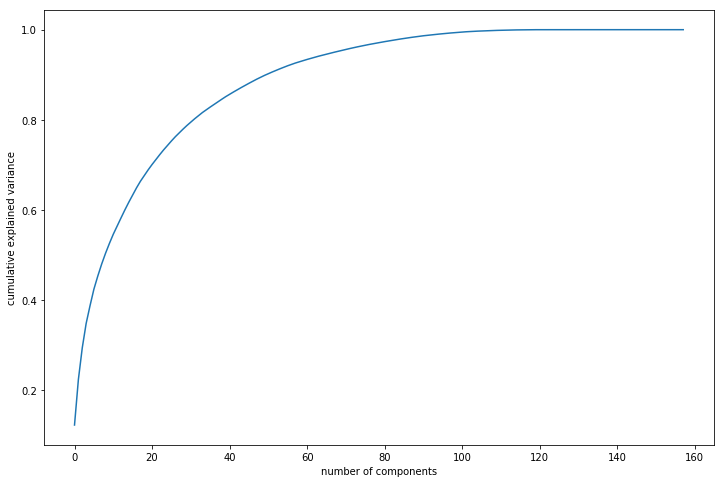

In [52]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

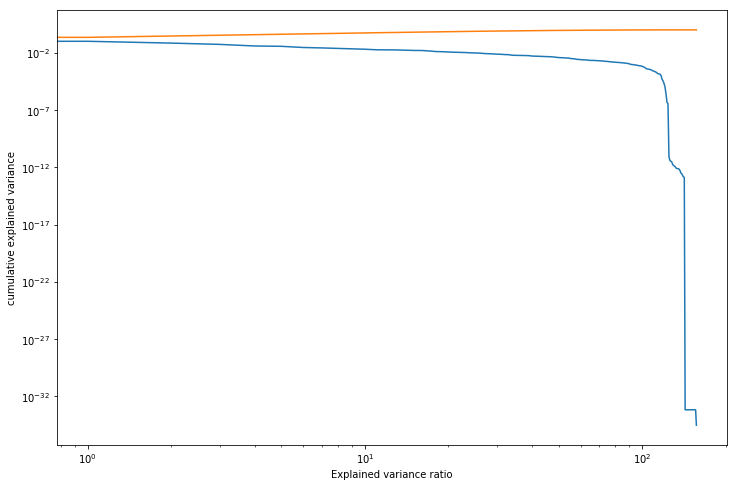

In [53]:
#Making the screeplot - plotting the cumulative variance against the explained variance ration
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.yscale('log')
plt.xscale('log')
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Explained variance ratio')
plt.ylabel('cumulative explained variance')
plt.show()

In [54]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=82)

In [55]:
help(PCA)

Help on class PCA in module sklearn.decomposition.pca:

class PCA(sklearn.decomposition.base._BasePCA)
 |  PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of com

In [56]:
df_train_pca = pca_final.fit_transform(Scaled_Xtrain)
df_train_pca.shape

(21240, 82)

In [57]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

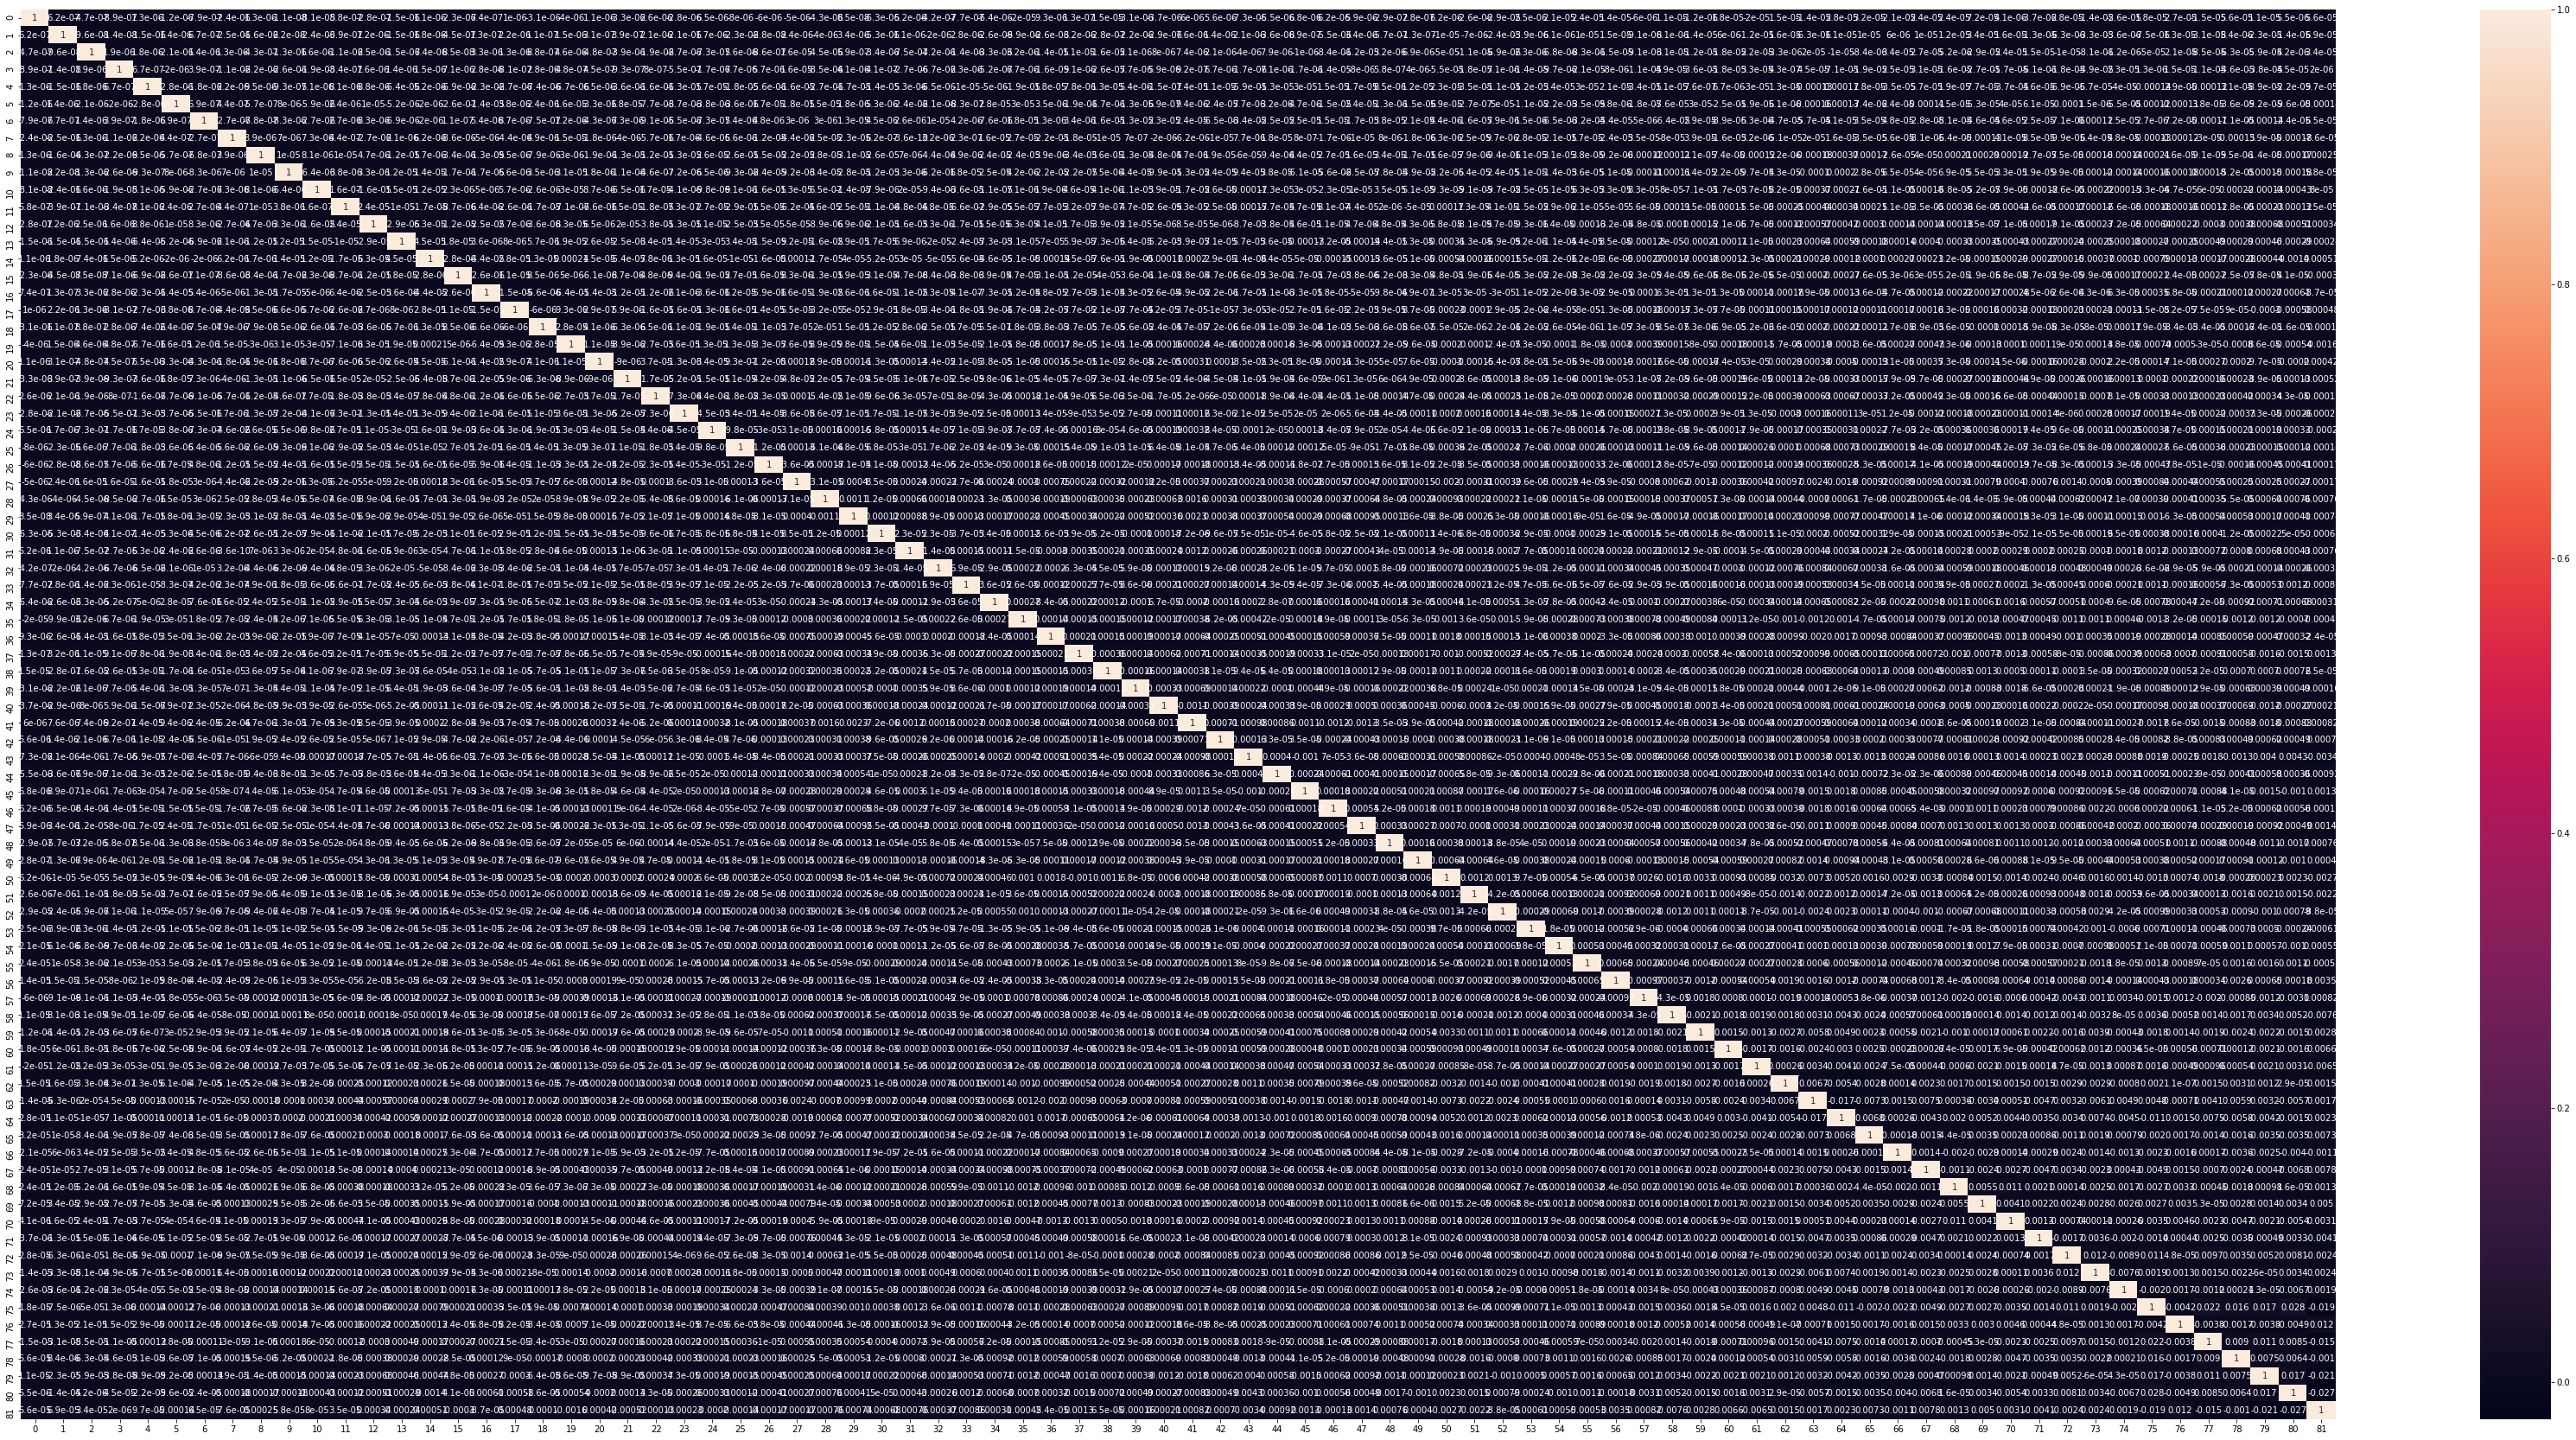

In [58]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (60,30))
sns.heatmap(corrmat,annot = True)

In [59]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.027732185810390268 , min corr:  -0.02684307427051088


In [60]:
#Applying selected components to the test data - 16 components
df_test_pca = pca_final.transform(Scaled_Xtest)
df_test_pca.shape

(9103, 82)

In [61]:
#Training the model on the train data
from sklearn.linear_model import LinearRegression
from sklearn import metrics

learner_pca = LinearRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [62]:
y_pred_pca = model_pca.predict(df_test_pca)

In [63]:
#from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_pca)
mse

0.05132636825696575

In [64]:
pca_2 = PCA(n_components=82,random_state=100)

In [65]:
df_train_pca = pca_2.fit_transform(Scaled_Xtrain)
df_train_pca.shape

(21240, 82)

In [66]:
#Applying selected components to the test data - 16 components
df_test_pca = pca_2.fit_transform(Scaled_Xtest)
df_test_pca.shape

(9103, 82)

In [67]:
#Training the model on the train data
from sklearn.linear_model import LinearRegression
from sklearn import metrics

learner_pca = LinearRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [68]:
y_pred_pca = model_pca.predict(df_test_pca)

In [69]:
#from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_pca)
mse

0.058836846241723785

In [70]:
y_pred_pca

array([0.08729128, 0.16875444, 0.06972392, ..., 0.20740531, 0.02298502,
       0.21852957])

In [71]:
import numpy as np
from sklearn import metrics
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred_pca)))

RMSE : 0.24256307683100448


In [72]:
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'PC4':pca.components_[3],'Feature':colnames})
pcs_df

PC1       PC2       PC3       PC4             Feature
0    0.049922  0.193078  0.062813 -0.004917              arpu_6
1    0.051828  0.199116  0.080704 -0.005205              arpu_7
2    0.056162  0.193568  0.065425  0.001875              arpu_8
3   -0.052616  0.086381  0.073664  0.046504         onnet_mou_6
4   -0.054195  0.094546  0.085593  0.051772         onnet_mou_7
5   -0.046119  0.095115  0.078730  0.054415         onnet_mou_8
6   -0.036540  0.137766  0.031749  0.038196        offnet_mou_6
7   -0.039102  0.143048  0.048222  0.039682        offnet_mou_7
8   -0.027931  0.139323  0.036894  0.043709        offnet_mou_8
9    0.003445  0.021989  0.015287 -0.024613       roam_ic_mou_6
10   0.006422  0.017173  0.013241 -0.030517       roam_ic_mou_7
11   0.007096  0.020870  0.012439 -0.021912       roam_ic_mou_8
12  -0.004755  0.031680  0.035443 -0.027789       roam_og_mou_6
13  -0.000288  0.031403  0.035502 -0.036234       roam_og_mou_7
14   0.001007  0.032708  0.034072 -0.030776       roam_og_mou_8
15   0.004052  0.065606 -0.081404  0.064568    loc_og_t2t_mou_6
16   0.002488  0.071498 -0.074541  0.070329    loc_og_t2t_mou_7
17   0.005290  0.072618 -0.074204  0.068519    loc_og_t2t_mou_8
18   0.013942  0.101562 -0.142158  0.046133    loc_og_t2m_mou_6
19   0.013056  0.107996 -0.140821  0.047659    loc_og_t2m_mou_7
20   0.018009  0.106806 -0.137835  0.047415    loc_og_t2m_mou_8
21   0.019800  0.046345 -0.086260 -0.027193    loc_og_t2f_mou_6
22   0.020097  0.046788 -0.085905 -0.028521    loc_og_t2f_mou_7
23   0.020747  0.046650 -0.084569 -0.027962    loc_og_t2f_mou_8
24   0.000411  0.010656  0.012802  0.036355    loc_og_t2c_mou_6
25  -0.003402  0.008257  0.023343  0.032767    loc_og_t2c_mou_7
26  -0.002609  0.010361  0.020168  0.033859    loc_og_t2c_mou_8
27   0.012683  0.109371 -0.147786  0.068693        loc_og_mou_6
28   0.011084  0.118443 -0.143497  0.075130        loc_og_mou_7
29   0.016006  0.117506 -0.140288  0.073089        loc_og_mou_8
..        ...       ...       ...       ...                 ...
128  0.171866  0.008856  0.041041 -0.066379           arpu_2g_8
129  0.149893 -0.046549  0.011035  0.092483    night_pck_user_6
130  0.150095 -0.046006  0.017719  0.098975    night_pck_user_7
131  0.141499 -0.032595  0.020110  0.103433    night_pck_user_8
132  0.053090 -0.022238 -0.026761  0.024069        monthly_2g_6
133  0.052297 -0.023839 -0.025176  0.026840        monthly_2g_7
134  0.051589 -0.019201 -0.026658  0.032205        monthly_2g_8
135  0.048852 -0.056476  0.043918  0.231974         sachet_2g_6
136  0.047443 -0.054837  0.048531  0.240638         sachet_2g_7
137  0.045232 -0.048892  0.047876  0.232941         sachet_2g_8
138  0.147061  0.001285  0.027791 -0.088610        monthly_3g_6
139  0.149884  0.004525  0.030854 -0.089538        monthly_3g_7
140  0.149843  0.009613  0.025076 -0.083823        monthly_3g_8
141  0.068751 -0.026382  0.041932  0.091198         sachet_3g_6
142  0.069230 -0.024167  0.051678  0.098815         sachet_3g_7
143  0.066324 -0.020649  0.050994  0.100481         sachet_3g_8
144  0.156817 -0.048912  0.004787  0.081059           fb_user_6
145  0.158265 -0.049153  0.010839  0.086951           fb_user_7
146  0.153882 -0.037765  0.011916  0.091644           fb_user_8
147  0.015451  0.015831 -0.104465 -0.040671                 aon
148  0.138104  0.001341  0.011980 -0.041594            vbc_3g_8
149  0.138524 -0.002845  0.015539 -0.041686            vbc_3g_7
150  0.135009 -0.001225  0.012494 -0.044593            vbc_3g_6
151  0.054847  0.211376  0.077736 -0.005458          arpu_2mths
152  0.058194  0.215510  0.077049 -0.002932          arpu_4mths
153  0.052397  0.210639  0.076645 -0.010597  avg_tot_rech_2mths
154  0.056000  0.214070  0.076843 -0.006239  avg_tot_rech_4mths
155  0.014925  0.015968 -0.103606 -0.040548           aon_years
156  0.092421  0.093116 -0.036532 -0.132333    avg_max_rech_amt
157  0.052397  0.210639  0.076645 -0.010597  avg_total_rech_amt

[158 rows x 5 columns]

In [73]:
len(pcs_df.Feature)    

158

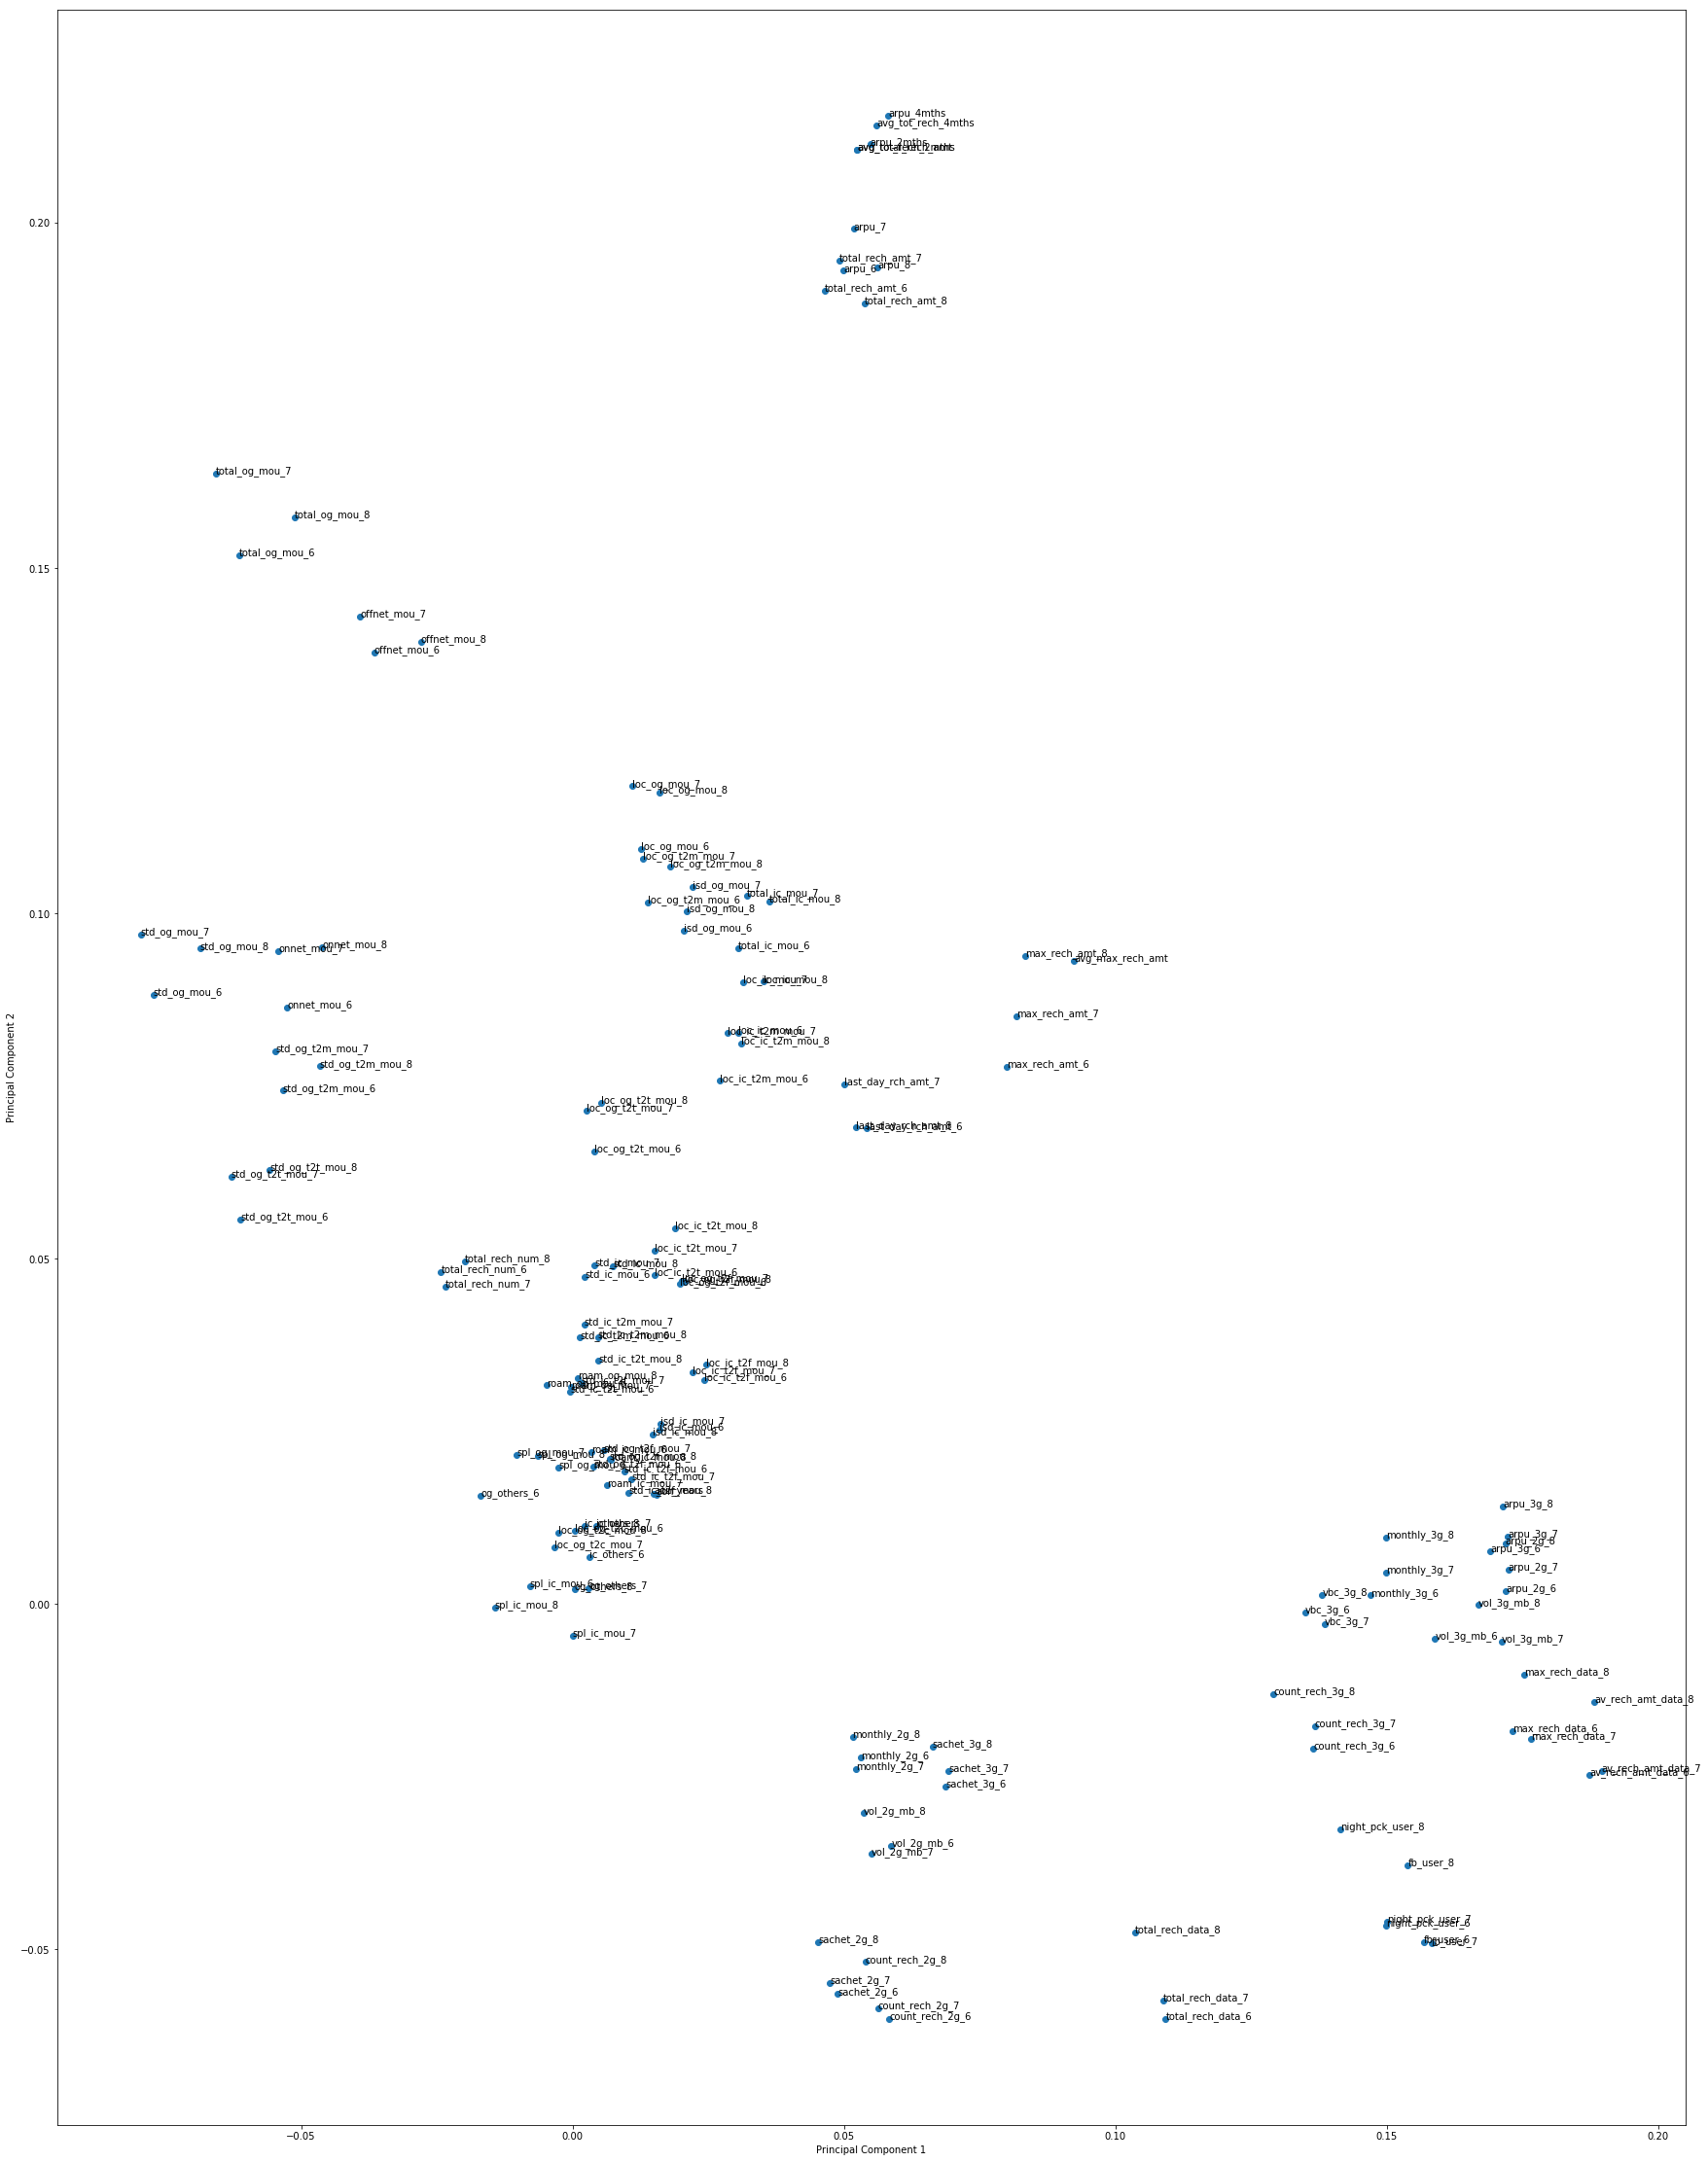

In [74]:
%matplotlib inline
fig = plt.figure(figsize = (30,40))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
#plt.tight_layout()
plt.show()

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [76]:
df_train_pca.shape

(21240, 82)

In [77]:
#training the regression model
LogSk_learner_pca2 = LogisticRegression(class_weight='balanced')
model_pca2 = LogSk_learner_pca2.fit(df_train_pca,y_train)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
#Making prediction on the test data
pred_probs_test= model_pca2.predict_proba(df_test_pca)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.65'

In [79]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_probs_test)

In [80]:
y_pred_df.head()

0
0  0.720619
1  0.855659
2  0.061241
3  0.188542
4  0.802920

In [81]:
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[0]]

In [82]:
y_pred_1.head()

0
0  0.720619
1  0.855659
2  0.061241
3  0.188542
4  0.802920

In [83]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn
87540      0
88274      1
17428      0
88159      1
92753      0

In [84]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [85]:
y_pred_1.head()

0
0  0.720619
1  0.855659
2  0.061241
3  0.188542
4  0.802920

In [86]:
y_test_df.head()

churn
0      0
1      1
2      0
3      1
4      0

In [87]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [88]:
y_pred_final.head()

churn         0
0      0  0.720619
1      1  0.855659
2      0  0.061241
3      1  0.188542
4      0  0.802920

In [89]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [90]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['churn','Churn_Prob'], axis=1)

C:\Users\Sameer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


In [91]:
# Let's see the head of y_pred_final
y_pred_final.head()

churn  Churn_Prob
0      0    0.720619
1      1    0.855659
2      0    0.061241
3      1    0.188542
4      0    0.802920

In [92]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [93]:
# Let's see the head
y_pred_final.head()

churn  Churn_Prob  predicted
0      0    0.720619          1
1      1    0.855659          1
2      0    0.061241          0
3      1    0.188542          0
4      0    0.802920          1

In [94]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6365, 2175],
       [ 279,  284]], dtype=int64)

In [95]:
# Predicted     not_churn    churn
# Actual
# not_churn        5685      2353
# churn            245       264 

In [96]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.predicted)

0.7304185433373613

In [97]:
TP = confusion[0,0] # true positive 
TN = confusion[1,1] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print(TP)
print(TN)
print(FP)
print(FN)

6365
284
2175
279


In [98]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0    0.720619          1    1    1    1    1    1    1    1    1    0   
1      1    0.855659          1    1    1    1    1    1    1    1    1    1   
2      0    0.061241          0    1    0    0    0    0    0    0    0    0   
3      1    0.188542          0    1    1    0    0    0    0    0    0    0   
4      0    0.802920          1    1    1    1    1    1    1    1    1    1   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

In [99]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.061848  0.000000  1.000000
0.1   0.1  0.301549  0.265105  0.854352
0.2   0.2  0.445787  0.425527  0.753108
0.3   0.3  0.557399  0.550117  0.667851
0.4   0.4  0.653631  0.657377  0.596803
0.5   0.5  0.730419  0.745316  0.504440
0.6   0.6  0.791607  0.818267  0.387211
0.7   0.7  0.844117  0.881733  0.273535
0.8   0.8  0.884653  0.930562  0.188277
0.9   0.9  0.912227  0.965457  0.104796


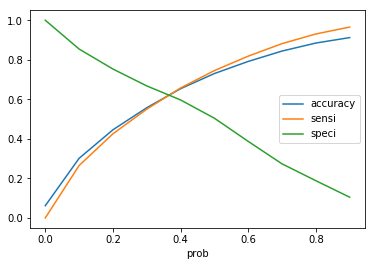

In [100]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [101]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.4 else 0)

In [102]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.final_predicted)

0.6536306712072943

In [103]:
metrics.confusion_matrix( y_pred_final.churn, y_pred_final.final_predicted )

array([[5614, 2926],
       [ 227,  336]], dtype=int64)

Reduced the TN , Predicted :-Not churn and actual Churn from 245 to 206

# Building And Evaluating Model for Identifying Important Driver Variables

## Boosting - XGBoost
### Applying XGBOOST on the actual variables

In [104]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

### Taking a copy of the dataframe from cleaned_df

In [105]:
df_for_boostinf = df

In [106]:
### Removing not required columns

In [107]:
df_for_boostinf = df_for_boostinf.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8', 'aon_group', 'arpu_group_2mths', 'arpu_group_4mths', 'max_rech_amt_group_2mths', 'total_rech_amt_group_2mths'],axis=1)

In [108]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = df_for_boostinf.drop(['churn'],axis=1)

# Putting response variable to y
y = df_for_boostinf['churn']

In [109]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [110]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [111]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[0.9960151 , 0.00398495],
       [0.87357605, 0.12642398],
       [0.99567515, 0.00432487],
       [0.32506597, 0.674934  ],
       [0.62755704, 0.372443  ],
       [0.9957082 , 0.0042918 ],
       [0.9408417 , 0.05915835],
       [0.98267734, 0.01732266],
       [0.65120643, 0.34879357],
       [0.9569296 , 0.04307037]], dtype=float32)

In [112]:
# evaluate predictions
import sklearn.metrics as metrics
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("Area under the curve: %.2f%%" % (roc * 100.0))

Area under the curve: 91.01%


In [113]:
# hyperparameter tuning with XGBoost
from sklearn.model_selection import GridSearchCV
# creating 3 Fold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



### this step might take more than two minutes..

In [114]:
# fit the model
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [115]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.557237      0.284309         0.086179        0.005588   
1      15.098465      0.064257         0.087682        0.010282   
2      15.553502      0.360238         0.075342        0.003909   
3      12.549470      0.254449         0.088752        0.011028   
4      15.151071      0.077667         0.082177        0.008252   
5      15.430247      0.367536         0.080209        0.001945   

  param_learning_rate param_subsample  \
0                 0.2             0.3   
1                 0.2             0.6   
2                 0.2             0.9   
3                 0.6             0.3   
4                 0.6             0.6   
5                 0.6             0.9   

                                     params  split0_test_score  \
0  {'learning_rate': 0.2, 'subsample': 0.3}           0.884454   
1  {'learning_rate': 0.2, 'subsample': 0.6}           0.890955   
2  {'learning_rate': 0.2, 'subsample': 0.9}           0.897647   
3  {'learning_rate': 0.6, 'subsample': 0.3}           0.841171   
4  {'learning_rate': 0.6, 'subsample': 0.6}           0.861843   
5  {'learning_rate': 0.6, 'subsample': 0.9}           0.872893   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.891810           0.893135         0.889799        0.003819   
1           0.903347           0.907419         0.900573        0.007002   
2           0.906393           0.904458         0.902832        0.003751   
3           0.840302           0.857288         0.846253        0.007811   
4           0.867966           0.880583         0.870130        0.007802   
5           0.884022           0.892827         0.883246        0.008157   

   rank_test_score  split0_train_score  split1_train_score  \
0                3            0.958371            0.957665   
1                2            0.965923            0.966772   
2                1            0.967596            0.966427   
3                6            0.965884            0.960499   
4                5            0.988162            0.987982   
5                4            0.991968            0.992453   

   split2_train_score  mean_train_score  std_train_score  
0            0.957984          0.958006         0.000289  
1            0.964255          0.965650         0.001046  
2            0.965635          0.966553         0.000806  
3            0.958930          0.961771         0.002978  
4            0.987321          0.987821         0.000362  
5            0.992170          0.992197         0.000199

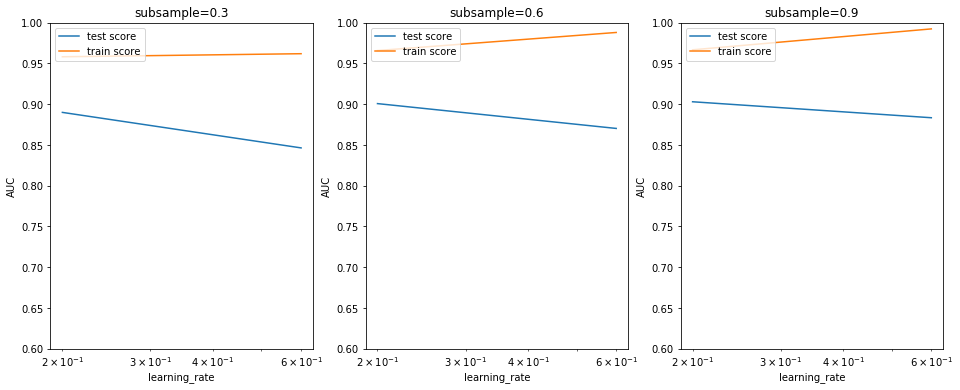

In [116]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    plt.subplot(1,len(param_grid['subsample']), n+1)
    plot_df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(plot_df["param_learning_rate"], plot_df["mean_test_score"])
    plt.plot(plot_df["param_learning_rate"], plot_df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [117]:
# chosen hyperparameters
# from the above graph it is evident that learning_rate =0.2 and subsample=0.9 produces a model with higher AUC with overfitting.
#so using those parameters for the final model.
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic',
       params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9, 'objective': 'binary:logistic'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [118]:
# predict
#y_pred_actual was for the predictions interms of churns
#y_pred is for probabilistic predictions used for AUC.
y_pred_actual = model.predict(X_test)
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[0.9960151 , 0.00398495],
       [0.87357605, 0.12642398],
       [0.99567515, 0.00432487],
       [0.32506597, 0.674934  ],
       [0.62755704, 0.372443  ],
       [0.9957082 , 0.0042918 ],
       [0.9408417 , 0.05915835],
       [0.98267734, 0.01732266],
       [0.65120643, 0.34879357],
       [0.9569296 , 0.04307037]], dtype=float32)

In [119]:
# roc_auc
import sklearn
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.9100704655970651

### AUC is 91.69 %

### Measuring accuracy, specificity and sensitivity in both training and test data, to check if the class imbalance had any ill effect on the model.

### Accuracy, specificity and sensitivity for test data (with Confusion matrix)

In [120]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

confusion_matrix_testData = confusion_matrix(y_test,y_pred_actual)
print(confusion_matrix(y_test,y_pred_actual))
total1=sum(sum(confusion_matrix_testData))
accuracy1=(confusion_matrix_testData[0,0]+confusion_matrix_testData[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_testData[0,0]/(confusion_matrix_testData[0,0]+confusion_matrix_testData[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_testData[1,1]/(confusion_matrix_testData[1,0]+confusion_matrix_testData[1,1])
print('Specificity : ', specificity1)

[[8423  117]
 [ 379  184]]
Accuracy :  0.9455124684170054
Sensitivity :  0.9862997658079625
Specificity :  0.3268206039076377


### Accuracy, specificity and sensitivity for train data (with Confusion matrix)

In [121]:
y_pred_train = model.predict(X_train)

In [122]:
# Confusion matrix sensitivity and specificity for training data
confusion_matrix_trainData = confusion_matrix(y_train,y_pred_train)
print(confusion_matrix_trainData)
total2=sum(sum(confusion_matrix_trainData))
accuracy2=(confusion_matrix_trainData[0,0]+confusion_matrix_trainData[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = confusion_matrix_trainData[0,0]/(confusion_matrix_trainData[0,0]+confusion_matrix_trainData[0,1])
print('Sensitivity : ', sensitivity2 )

specificity2 = confusion_matrix_trainData[1,1]/(confusion_matrix_trainData[1,0]+confusion_matrix_trainData[1,1])
print('Specificity : ', specificity2)

[[19674   254]
 [  793   519]]
Accuracy :  0.9507062146892655
Sensitivity :  0.987254114813328
Specificity :  0.3955792682926829


### Based on the above results for Accuracy, specificity and sensitivity for both training and test data,
### there wasn't much deviation except for specificity. So there doesn't seem to be overfitting.

### List of Important features

In [123]:
# feature importance
feature_importance = dict(zip(X_train.columns, model.feature_importances_))
feature_importance

{'mobile_number': 0.0025219012,
 'arpu_6': 0.005444597,
 'arpu_7': 0.0068561276,
 'arpu_8': 0.010853739,
 'onnet_mou_6': 0.0064396877,
 'onnet_mou_7': 0.0,
 'onnet_mou_8': 0.0,
 'offnet_mou_6': 0.0057833344,
 'offnet_mou_7': 0.005425881,
 'offnet_mou_8': 0.0042038797,
 'roam_ic_mou_6': 0.0,
 'roam_ic_mou_7': 0.0067090816,
 'roam_ic_mou_8': 0.018499902,
 'roam_og_mou_6': 0.004412078,
 'roam_og_mou_7': 0.009460246,
 'roam_og_mou_8': 0.0169753,
 'loc_og_t2t_mou_6': 0.00288371,
 'loc_og_t2t_mou_7': 0.010464037,
 'loc_og_t2t_mou_8': 0.005135383,
 'loc_og_t2m_mou_6': 0.0046302783,
 'loc_og_t2m_mou_7': 0.005424061,
 'loc_og_t2m_mou_8': 0.019572046,
 'loc_og_t2f_mou_6': 0.013359452,
 'loc_og_t2f_mou_7': 0.003566007,
 'loc_og_t2f_mou_8': 0.028898887,
 'loc_og_t2c_mou_6': 0.0019678029,
 'loc_og_t2c_mou_7': 0.0033502341,
 'loc_og_t2c_mou_8': 0.010291203,
 'loc_og_mou_6': 0.0014873751,
 'loc_og_mou_7': 0.011022447,
 'loc_og_mou_8': 0.012692819,
 'std_og_t2t_mou_6': 0.0,
 'std_og_t2t_mou_7': 0.0033

In [124]:
import operator
columns_sorted_descending_importance = sorted(feature_importance.items(), key=operator.itemgetter(1),reverse=True)

In [125]:
columns_sorted_descending_importance

[('total_ic_mou_8', 0.08300747),
 ('loc_ic_mou_8', 0.069328904),
 ('fb_user_8', 0.04874769),
 ('av_rech_amt_data_7', 0.035108663),
 ('loc_ic_t2m_mou_8', 0.033103976),
 ('loc_og_t2f_mou_8', 0.028898887),
 ('last_day_rch_amt_8', 0.022734357),
 ('loc_og_t2m_mou_8', 0.019572046),
 ('std_og_mou_7', 0.019319959),
 ('roam_ic_mou_8', 0.018499902),
 ('av_rech_amt_data_8', 0.018009093),
 ('roam_og_mou_8', 0.0169753),
 ('loc_og_t2f_mou_6', 0.013359452),
 ('max_rech_data_7', 0.012762363),
 ('loc_og_mou_8', 0.012692819),
 ('max_rech_data_8', 0.012307109),
 ('total_rech_num_7', 0.012187269),
 ('avg_max_rech_amt', 0.0116527015),
 ('arpu_2g_7', 0.0114441505),
 ('loc_og_mou_7', 0.011022447),
 ('total_ic_mou_7', 0.010890438),
 ('arpu_8', 0.010853739),
 ('total_rech_amt_8', 0.010581813),
 ('loc_og_t2t_mou_7', 0.010464037),
 ('loc_og_t2c_mou_8', 0.010291203),
 ('total_og_mou_8', 0.009791962),
 ('roam_og_mou_7', 0.009460246),
 ('arpu_2mths', 0.0093544675),
 ('spl_ic_mou_8', 0.008927239),
 ('loc_ic_mou_6', 

## Random Forest

In [126]:
X_train.shape

(21240, 159)

In [127]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight={0:0.9,1:0.9})

In [128]:
# fit
rfc.fit(X_train,y_train)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight={0: 0.9, 1: 0.9},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [129]:
# Making predictions
predictions = rfc.predict(X_test)

In [130]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [131]:
# Let's check the report of our default model
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8540
           1       0.59      0.24      0.34       563

   micro avg       0.94      0.94      0.94      9103
   macro avg       0.77      0.61      0.65      9103
weighted avg       0.93      0.94      0.93      9103



In [132]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[8446   94]
 [ 430  133]]


In [133]:
print(accuracy_score(y_test,predictions))

0.9424365593760299


In [134]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                return_train_score=True)
rf.fit(X_train, y_train)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [135]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.185874      0.011022         0.008037        0.006994   
1       0.487009      0.008139         0.008777        0.004478   
2       0.802590      0.018557         0.015902        0.009555   
3       1.095408      0.103106         0.018303        0.002613   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.939044           0.939044   
1               7   {'max_depth': 7}           0.946576           0.944458   
2              12  {'max_depth': 12}           0.945399           0.941633   
3              17  {'max_depth': 17}           0.946340           0.942104   

   split2_test_score  split3_test_score       ...         mean_test_score  \
0           0.938324           0.938309       ...                0.939407   
1           0.946328           0.943490       ...                0.945527   
2           0.945621           0.940899       ...                0.943550   
3           0.943032           0.943960       ...                0.943738   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.001489                4            0.939439            0.942558   
1        0.001313                1            0.953387            0.953152   
2        0.001940                3            0.974810            0.975693   
3        0.001430                2            0.989818            0.989818   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.938206            0.938210            0.940858   
1            0.953449            0.953628            0.951568   
2            0.974694            0.976932            0.977285   
3            0.989466            0.991114            0.991526   

   mean_train_score  std_train_score  
0          0.939854         0.001668  
1          0.953037         0.000750  
2          0.975883         0.001064  
3          0.990348         0.000814  

[4 rows x 21 columns]

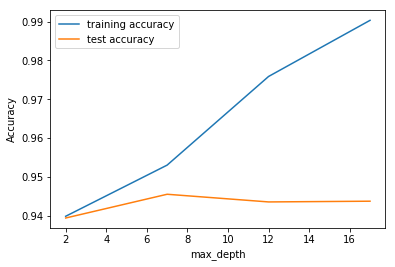

In [136]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [137]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(1, 10, 1)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(1, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [138]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.149586      0.019816         0.007380        0.000489   
1       0.243730      0.017309         0.007844        0.006986   
2       0.344794      0.016470         0.012040        0.002959   
3       0.445727      0.013228         0.011557        0.002196   
4       0.544232      0.019250         0.011296        0.002183   

  param_n_estimators               params  split0_test_score  \
0                  1  {'n_estimators': 1}           0.905390   
1                  2  {'n_estimators': 2}           0.939044   
2                  3  {'n_estimators': 3}           0.936926   
3                  4  {'n_estimators': 4}           0.942810   
4                  5  {'n_estimators': 5}           0.943045   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0           0.911038           0.909840           0.910290       ...          
1           0.941163           0.938559           0.937132       ...          
2           0.933161           0.935970           0.938074       ...          
3           0.940692           0.946563           0.940193       ...          
4           0.942104           0.944209           0.936426       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.909134        0.001974                9            0.967748   
1         0.938465        0.001647                7            0.973869   
2         0.935546        0.001895                8            0.983756   
3         0.942232        0.002341                3            0.981225   
4         0.941337        0.002686                5            0.991937   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.965747            0.964925            0.967281   
1            0.972574            0.971163            0.971459   
2            0.986758            0.985876            0.987348   
3            0.981108            0.982874            0.984052   
4            0.991231            0.991172            0.990820   

   split4_train_score  mean_train_score  std_train_score  
0            0.968870          0.966914         0.001412  
1            0.972812          0.972375         0.000977  
2            0.986406          0.986029         0.001233  
3            0.982993          0.982451         0.001126  
4            0.990702          0.991172         0.000432  

[5 rows x 21 columns]

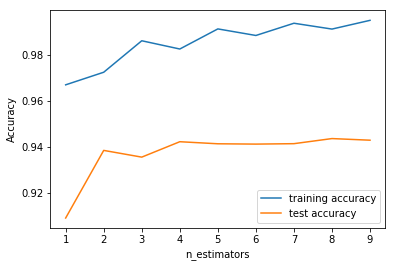

In [139]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [140]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [10, 25, 50, 75 , 100]} 

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train, y_train)

C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Sameer\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [10, 25, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [141]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.889040      0.042296         0.015148        0.000643   
1       2.594638      0.142992         0.014234        0.001186   
2       5.509393      0.193718         0.014769        0.001098   
3       9.106739      0.505873         0.019610        0.007753   
4      13.045921      0.372671         0.009302        0.007601   

  param_max_features                 params  split0_test_score  \
0                 10   {'max_features': 10}           0.946105   
1                 25   {'max_features': 25}           0.944928   
2                 50   {'max_features': 50}           0.944693   
3                 75   {'max_features': 75}           0.943987   
4                100  {'max_features': 100}           0.942339   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0           0.939986           0.944915           0.944431       ...          
1           0.943987           0.944209           0.940664       ...          
2           0.940927           0.943503           0.940664       ...          
3           0.939986           0.941384           0.944196       ...          
4           0.942339           0.943503           0.943254       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.944209        0.002188                1            0.993291   
1         0.943409        0.001472                2            0.993703   
2         0.943267        0.002241                3            0.993467   
3         0.943267        0.002370                3            0.994173   
4         0.942985        0.000535                5            0.993291   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.992820            0.993056            0.992173   
1            0.993349            0.993350            0.993880   
2            0.993291            0.994880            0.992997   
3            0.993232            0.993644            0.993821   
4            0.994291            0.992290            0.993939   

   split4_train_score  mean_train_score  std_train_score  
0            0.993527          0.992973         0.000464  
1            0.993468          0.993550         0.000209  
2            0.993762          0.993679         0.000650  
3            0.994174          0.993809         0.000354  
4            0.993527          0.993468         0.000681  

[5 rows x 21 columns]

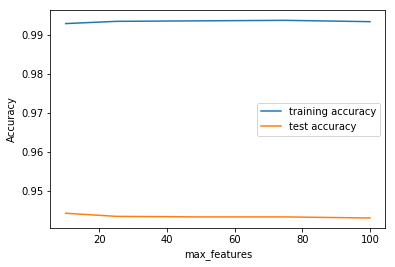

In [142]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [143]:
# Create the parameter grid based on the results of random search  
param_grid = {     'max_depth': [2,4,6],
                   'n_estimators': [1,2,3],
                   'max_features': [5,15,25] } 

# Create a based model 
rf = RandomForestClassifier() 

# Instantiate the grid search 
model_GSV = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1,verbose = 1) 

# Fit the grid search to the data grid_search.fit(X_train, y_train) 
model_GSV.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   10.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6], 'n_estimators': [1, 2, 3], 'max_features': [5, 15, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [144]:
print('We can get accuracy of',model_GSV.best_score_,'using',model_GSV.best_params_)

We can get accuracy of 0.9452448210922787 using {'max_depth': 6, 'max_features': 15, 'n_estimators': 3}


In [145]:
# model with the best hyperparameters from sklearn.ensemble
rfc_best = RandomForestClassifier(bootstrap=True,         max_depth=4,
                                                           max_features=20,
                                                           n_estimators=2,
                                                           class_weight={0:0.9,1:0.9}) 
rfc_best.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, class_weight={0: 0.9, 1: 0.9},
            criterion='gini', max_depth=4, max_features=20,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [146]:
# Making predictions
predictions_inc = rfc_best.predict(X_test)

In [147]:
predictions_inc

array([0, 0, 0, ..., 0, 0, 0])

In [148]:
print(metrics.classification_report(y_test,predictions_inc))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8540
           1       0.58      0.20      0.30       563

   micro avg       0.94      0.94      0.94      9103
   macro avg       0.76      0.60      0.63      9103
weighted avg       0.93      0.94      0.93      9103



In [149]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions_inc))

[[8457   83]
 [ 449  114]]


In [150]:
print(accuracy_score(y_test,predictions_inc))

0.9415577282214654


In [151]:
import pandas as pd
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [152]:
feature_importances.head(25)

importance
loc_ic_mou_8          0.050806
total_ic_mou_8        0.025176
loc_ic_t2m_mou_8      0.024748
arpu_8                0.023586
total_og_mou_8        0.023518
roam_ic_mou_8         0.023223
loc_og_mou_8          0.022297
last_day_rch_amt_8    0.019894
roam_og_mou_8         0.017502
loc_ic_t2t_mou_8      0.017168
total_rech_amt_8      0.015673
max_rech_amt_8        0.012068
onnet_mou_6           0.011865
aon                   0.011536
total_ic_mou_7        0.011389
loc_og_t2m_mou_8      0.011012
mobile_number         0.010879
loc_ic_t2m_mou_6      0.010854
total_rech_num_7      0.010665
loc_og_t2t_mou_8      0.010363
avg_max_rech_amt      0.010326
arpu_7                0.010210
max_rech_data_8       0.009828
fb_user_8             0.009660
roam_og_mou_7         0.009597

In [153]:
import pandas as pd
feature_importances_afterHPTuning= pd.DataFrame(rfc_best.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_afterHPTuning.head(10)

importance
loc_ic_t2t_mou_8      0.251573
total_rech_amt_8      0.136757
loc_og_t2m_mou_8      0.100029
std_ic_mou_8          0.096215
av_rech_amt_data_8    0.090079
std_ic_mou_6          0.089771
roam_og_mou_8         0.079207
std_og_mou_8          0.025719
offnet_mou_8          0.019818
std_og_mou_7          0.018651

#### The top 6 features comprising of more than 75% importances are,
1.loc_og_mou_8
2.total_ic_mou_8
3.last_day_rch_amt_8
4.std_ic_mou_8
5.loc_ic_t2m_mou_8
6.roam_og_mou_8

In [154]:
print(max(rfc.feature_importances_))

0.05080592983848289


In [155]:
print(max(rfc_best.feature_importances_))

0.25157338031465415


In [156]:
#Making prediction on the test data
pred_probs_test= rfc_best.predict_proba(X_test)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.84'

In [157]:
y_pred_df = pd.DataFrame(pred_probs_test)
y_pred_df.head()

0
0  0.012948
1  0.201806
2  0.012948
3  0.119504
4  0.490959

In [158]:
y_pred_1 = y_pred_df.iloc[:,[0]]
y_pred_1.head()

0
0  0.012948
1  0.201806
2  0.012948
3  0.119504
4  0.490959

In [159]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn
87540      0
88274      1
17428      0
88159      1
92753      0

In [160]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True,inplace=True)

In [161]:
y_pred_1.head()

0
0  0.012948
1  0.201806
2  0.012948
3  0.119504
4  0.490959

In [162]:
y_test_df.head()

churn
0      0
1      1
2      0
3      1
4      0

In [163]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [164]:
y_pred_final.head()

churn         0
0      0  0.012948
1      1  0.201806
2      0  0.012948
3      1  0.119504
4      0  0.490959

In [165]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [166]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['churn','Churn_Prob'], axis=1)

C:\Users\Sameer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


In [167]:
# Let's see the head of y_pred_final
y_pred_final.head()

churn  Churn_Prob
0      0    0.012948
1      1    0.201806
2      0    0.012948
3      1    0.119504
4      0    0.490959

In [168]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [169]:
# Let's see the head
y_pred_final.head()


churn  Churn_Prob  predicted
0      0    0.012948          0
1      1    0.201806          0
2      0    0.012948          0
3      1    0.119504          0
4      0    0.490959          0

In [170]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[8457,   83],
       [ 449,  114]], dtype=int64)

In [171]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.predicted)

0.9415577282214654

In [172]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0    0.012948          0    1    0    0    0    0    0    0    0    0   
1      1    0.201806          0    1    1    1    0    0    0    0    0    0   
2      0    0.012948          0    1    0    0    0    0    0    0    0    0   
3      1    0.119504          0    1    1    0    0    0    0    0    0    0   
4      0    0.490959          0    1    1    1    1    1    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

In [173]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.061848  0.000000  1.000000
0.1   0.1  0.860266  0.872717  0.671403
0.2   0.2  0.924860  0.953279  0.493783
0.3   0.3  0.941338  0.977049  0.399645
0.4   0.4  0.943425  0.983021  0.342806
0.5   0.5  0.941558  0.990281  0.202487
0.6   0.6  0.941997  0.990749  0.202487
0.7   0.7  0.938152  1.000000  0.000000
0.8   0.8  0.938152  1.000000  0.000000
0.9   0.9  0.938152  1.000000  0.000000


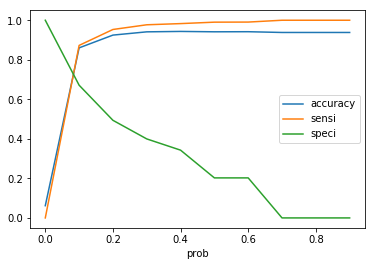

In [174]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [175]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.1 else 0)

In [176]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.final_predicted)

0.8602658464242557

In [177]:
metrics.confusion_matrix( y_pred_final.churn, y_pred_final.final_predicted )

array([[7453, 1087],
       [ 185,  378]], dtype=int64)

In [178]:
import pandas as pd
feature_importances_afterHPTuning= pd.DataFrame(rfc_best.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_afterHPTuning.head(10)

importance
loc_ic_t2t_mou_8      0.251573
total_rech_amt_8      0.136757
loc_og_t2m_mou_8      0.100029
std_ic_mou_8          0.096215
av_rech_amt_data_8    0.090079
std_ic_mou_6          0.089771
roam_og_mou_8         0.079207
std_og_mou_8          0.025719
offnet_mou_8          0.019818
std_og_mou_7          0.018651

## Evaluating the Models

#### Results with PCA based logistic regression:
Confusion Matrix:

[5614, 2926]

[ 227,  336]]

Accuracy: 0.6536306712072943

#### Results with XGBoost model:
Confusion Matrix:

[[8423 ,  117]

[ 379 ,  184]]

Accuracy :  0.9455124684170054
Sensitivity :  0.9862997658079625
Specificity :  0.3268206039076377

#### Results with Random Forest:
Confusion Matrix:

[[8429 ,  111]

[ 395 , 168]]

Accuracy: 0.9444139294737999

Accuracy is measured using AUC
Based on the confusion matrix and accuracy, the model chosen is XGBoost to identify the churners

### Driver variables

#### Driver variables identified from XGBoost
In the order of importane (Descending)

roam_og_mou_8

total_rech_amt_8

last_day_rch_amt_8

av_rech_amt_data_8

aon

total_ic_mou_8

total_og_mou_8

roam_ic_mou_8

loc_ic_mou_8

spl_ic_mou_8

#### Driver variables identified from Random Forest
In the order of importane (Descending)

total_og_mou_8

arpu_8

vol_3g_mb_7

max_rech_data_8

loc_og_mou_8

av_rech_amt_data_8

roam_og_mou_8

loc_og_t2f_mou_8

loc_ic_t2m_mou_8

total_ic_mou_8


#### Chosen Driver variables

roam_og_mou_8

total_rech_amt_8

last_day_rch_amt_8

av_rech_amt_data_8

aon

total_og_mou_8

arpu_8

vol_3g_mb_7

max_rech_data_8

loc_og_mou_8

# Summary and Recommendations

1. Offer discounted roaming outgoing packs

2. Monitor the total recharge, offer additional talk time with additional validity on the recharges

3. Give more discount to the customers who have been with the network for more than an year or less than 3 months

4. Give additional data on data pack recharges (for 7th month)

5. Based on the usage / last recharge, if the usage is less compared to previous months, speak to the customer to know his concerns